# Fluxonium Design with 6 single qubits
 In this JN we extract the followings:
- 1. The resonator frequencies
- 2. We use two eigenmode to obtain more parameters from the qubit and resonator modes
- 3. After having all the desired circuit parameters, we can extract the .GDS file

This JN is created by Figen Yilmaz
### Preparations

In [1]:
# For convenience, let's begin by enabling
# automatic reloading of modules when they change.
%load_ext autoreload
%autoreload 2

import numpy as np
from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict

from qiskit_metal.toolbox_metal import math_and_overrides

from qiskit_metal.qlibrary.core import QComponent

from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors

from qiskit_metal.qlibrary.qubits.fluxonium import FluxoniumPocket

from qiskit_metal.qlibrary.terminations.ebeam_marker import Markers
from qiskit_metal.qlibrary.terminations.ebeam_frame import Frame

from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond

from qiskit_metal.qlibrary.terminations.open_to_ground_v2 import OpenToGround
from qiskit_metal.renderers.renderer_ansys.ansys_renderer import QAnsysRenderer

from qiskit_metal.analyses.sweep_and_optimize.sweeping import Sweeping


import pyEPR as epr
from qiskit_metal.analyses.quantization import EPRanalysis

In [2]:
# Each time you create a new quantum circuit design,
# you start by instantiating a QDesign class.

# The design class `DesignPlanar` is best for 2D circuit designs.
design = designs.DesignPlanar()
design.chips.main.material = 'silicon'
design.variables['cpw_width'] = '15 um'
design.variables['cpw_gap'] = '8.733 um'
design._chips['main']['size']['size_x'] = '9mm'
design._chips['main']['size']['size_y'] = '9mm'
design._chips['main']['size']['size_z'] = '-525um' #Our wafer thicknes is 525 um+/-10

# If you disable the next line with "overwrite_enabled", then you will need to
# delete a component [<component>.delete()] before recreating it.
design.overwrite_enabled = True

eig_qres = EPRanalysis(design, "hfss")
hfss = design.renderers.hfss
hfss = eig_qres.sim.renderer
q3d = design.renderers.q3d

gui = MetalGUI(design)

In [3]:
from qiskit_metal.qlibrary.terminations.ebeam_marker_v2 import Markers
from qiskit_metal.qlibrary.terminations.ebeam_frame import Frame

## Markers for ebeam
options = dict(pos_x='3.6mm', pos_y='4.20mm',
                    )
mrk1 = Markers(design, 'marker1', options = options)

options = dict(pos_x='-3.6mm', pos_y='4.20mm',
                    )
mrk2 = Markers(design, 'marker2', options = options)

options = dict(pos_x='-3.6mm', pos_y='-4.20mm',
                    )
mrk3 = Markers(design, 'marker3', options = options)

options = dict(pos_x='3.6mm', pos_y='-4.20mm',
                    )
mrk4 = Markers(design, 'marker4', options = options)

## Having the frame around the device for Disco Dicer
options = dict(chip='main')
frame = Frame(design, 'frame', options = options)

gui.rebuild()

In [4]:
#Setup the launchpad1 location and orientation
## Read In launch pad
launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='-3.85mm', orientation='0',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um',
                    )
lp = LaunchpadWirebond(design, 'LPReadIn', options = launch_options)


# Read Out launch pad
launch_options = dict(chip='main', pos_x='4.0mm', pos_y='3.6mm', orientation='180',
                      lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um',
                    )
lp = LaunchpadWirebond(design, 'LPReadOut', options = launch_options)


Transmission_Line = {'pin_inputs':
           {'start_pin': {'component': 'LPReadIn', 'pin': 'tie'},
             'end_pin': {'component': 'LPReadOut', 'pin': 'tie'}},
            'lead': {'start_straight': '3970um', 'end_straight': '3970um',
                    }, 
                    'total_length': '8mm', 'fillet': "90um"
            }

TransLine = RoutePathfinder(design, 'TL', Transmission_Line)


gui.rebuild()

In [5]:
## Q1 flux-bias and charge line's lauch pad
launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='-2.66mm', orientation='0',
                      lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um',
                    )
lp = LaunchpadWirebond(design, 'LPCL1', options = launch_options)

launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='-1.33mm', orientation='0',
                     lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um',
                    )
lp = LaunchpadWirebond(design, 'LPFB1', options = launch_options)


## Q2 flux-bias and charge line's lauch pad
launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='-0.2mm', orientation='0',
                      lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um',
                    )
lp = LaunchpadWirebond(design, 'LPCL2', options = launch_options)

launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='+1.0mm', orientation='0',
                      lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um',
                    )
lp = LaunchpadWirebond(design, 'LPFB2', options = launch_options)


## Q3 flux-bias and charge line's lauch pad
launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='2.20mm', orientation='0',
                      lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um',
                    )
lp = LaunchpadWirebond(design, 'LPCL3', options = launch_options)

launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='3.6mm', orientation='0',
                      lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um',
                    )
lp = LaunchpadWirebond(design, 'LPFB3', options = launch_options)


## Q4 flux-bias and charge line's lauch pad
launch_options = dict(chip='main', pos_x='4.0mm', pos_y='2.40mm', orientation='180',
                      lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um',
                    )
lp = LaunchpadWirebond(design, 'LPFB4', options = launch_options)

launch_options = dict(chip='main', pos_x='4.0mm', pos_y='1.0mm', orientation='180',
                      lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um',
                    )
lp = LaunchpadWirebond(design, 'LPCL4', options = launch_options)


## Q5 flux-bias and charge line's lauch pad
launch_options = dict(chip='main', pos_x='4.0mm', pos_y='-0.2mm', orientation='180',
                      lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um',
                    )
lp = LaunchpadWirebond(design, 'LPFB5', options = launch_options)

launch_options = dict(chip='main', pos_x='4.0mm', pos_y='-1.33mm', orientation='180',
                      lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um',
                    )
lp = LaunchpadWirebond(design, 'LPCL5', options = launch_options)


## Q6 flux-bias and charge line's lauch pad
launch_options = dict(chip='main', pos_x='4.0mm', pos_y='-2.66mm', orientation='180',
                      lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um',
                    )
lp = LaunchpadWirebond(design, 'LPFB6', options = launch_options)

launch_options = dict(chip='main', pos_x='4.0mm', pos_y='-3.85mm', orientation='180',
                      lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um',
                    )
lp = LaunchpadWirebond(design, 'LPCL6', options = launch_options)


gui.rebuild()

In [5]:
from qiskit_metal.qlibrary.qubits.fluxonium import FluxoniumPocket

gds_cell_name_jj = 'junction_0'
gds_cell_name_inductor = 'jj_array0'

# Q1 details
options = dict(chip='main', nanowire = False, 
            orientation =90, pos_x = '-2.2mm', pos_y = '-2.3mm',
            gds_cell_name=gds_cell_name_jj,
            gds_cell_inductor=gds_cell_name_inductor ,
               inductor_orientation='-1',
               
    flux_bias_line_options=Dict(make_fbl = True,
           ), 
               
    charge_line_options=Dict(loc_H = +1, make_cl = True,
                            ),
    readout_line_options=Dict(loc_H = -1, make_rol = True, 
              ) )
               
q1 = FluxoniumPocket(design,'Q1', options = dict(
             **options))

# Q6 details
options = dict(chip='main', nanowire = False,
        orientation =90, pos_x = '2.2mm', pos_y = '-2.4mm',
        gds_cell_name=gds_cell_name_jj,
        gds_cell_inductor=gds_cell_name_inductor ,
               inductor_orientation='-1',
               
    flux_bias_line_options=Dict(make_fbl = True,
        ), 
               
    charge_line_options=Dict(loc_H = -1, make_cl = True,
                            ), 
    readout_line_options=Dict(loc_H = +1, make_rol = True,
              ) )
               
q6 = FluxoniumPocket(design,'Q6', options = dict(
        **options))


# Q2 details
options = dict(chip='main', nanowire = False,
        orientation =90, pos_x = '-2.2mm', pos_y = '-0.2mm',
        gds_cell_name=gds_cell_name_jj,
        gds_cell_inductor=gds_cell_name_inductor ,
               inductor_orientation='-1',
               
    flux_bias_line_options=Dict(make_fbl = True,
         ), 
               
    charge_line_options=Dict(loc_H = +1, make_cl = True,
                            ),
    readout_line_options=Dict(loc_H = -1, make_rol = True,
              ) )
               
q2 = FluxoniumPocket(design,'Q2', options = dict(
        **options))

# Q5 details
options = dict(chip='main', nanowire = False,
        orientation =90, pos_x = '2.4mm', pos_y = '-0.8mm',
        gds_cell_name=gds_cell_name_jj,
               gds_cell_inductor=gds_cell_name_inductor ,
               inductor_orientation='-1',
                      
    flux_bias_line_options=Dict(make_fbl = True,
                            ), 
               
    charge_line_options=Dict(loc_H = -1, make_cl = True,
                            ), 
    readout_line_options=Dict(loc_H = +1, make_rol = True,
              ) )
               
q5 = FluxoniumPocket(design,'Q5', options = dict(
        **options))


# Q3 details
options = dict(chip='main', nanowire = False,
        orientation =90, pos_x = '-2.5mm', pos_y = '2.5mm',
        gds_cell_name=gds_cell_name_jj,
        gds_cell_inductor=gds_cell_name_inductor ,
               inductor_orientation='-1',
               
    flux_bias_line_options=Dict(make_fbl = True,
        ), 
               
    charge_line_options=Dict(loc_H = +1, make_cl = True,
                            ),
    readout_line_options=Dict(loc_H = -1, make_rol = True,
              ) )
               
q3 = FluxoniumPocket(design,'Q3', options = dict(
        **options))

# Q4 details
options = dict(chip='main', nanowire = False,
        orientation =90, pos_x = '2.4mm', pos_y = '2.0mm',
        gds_cell_name=gds_cell_name_jj,
        gds_cell_inductor=gds_cell_name_inductor,
               inductor_orientation='-1',
               
    flux_bias_line_options=Dict(make_fbl = True,
        ), 
               
    charge_line_options=Dict(loc_H = -1, make_cl = True,
                            ),
    readout_line_options=Dict(loc_H = 1, make_rol = True,
              ) )
               
q4 = FluxoniumPocket(design,'Q4', options = dict(
        **options))

# Q JJ1 test structure details
options = dict(chip='main',  nanowire = False,
        orientation =90, pos_x = '-1.0mm', pos_y = '1.0mm',
               pocket_width= '600um',
        gds_cell_name=gds_cell_name_jj,
               
    flux_bias_line_options=Dict(make_fbl = False), 
               
    charge_line_options=Dict(loc_H = -1, make_cl = False,
                            ),
    readout_line_options=Dict(loc_H = 1, make_rol = False,
              ) )
               
qJJ1 = FluxoniumPocket(design,'QJJ1', options = dict(
        **options))

# Q JJ2 test structure details
options = dict(chip='main', nanowire = False,
        orientation =90, pos_x = '-1.0mm', pos_y = '1.2mm',
               pocket_width= '600um',
        gds_cell_name=gds_cell_name_jj,   
               
    flux_bias_line_options=Dict(make_fbl = False), 
               
    charge_line_options=Dict(loc_H = -1, make_cl = False,
                            ),
    readout_line_options=Dict(loc_H = 1, make_rol = False,
              ) )
               
qJJ2 = FluxoniumPocket(design,'QJJ2', options = dict(
        **options))

# Q JJ3 test structure details
options = dict(chip='main', nanowire = False,
        orientation =90, pos_x = '-1.0mm', pos_y = '1.4mm',
               pocket_width= '600um',
        gds_cell_name=gds_cell_name_jj,  
               
    flux_bias_line_options=Dict(make_fbl = False), 
               
    charge_line_options=Dict(loc_H = -1, make_cl = False,
                            ),
    readout_line_options=Dict(loc_H = 1, make_rol = False,
              ) )
               
qJJ3 = FluxoniumPocket(design,'QJJ3', options = dict(
        **options))


# Q Array1 test structure details
options = dict(chip='main', nanowire = False, 
            orientation =90, pos_x = '1.0mm', pos_y = '0.7mm',
            gds_cell_inductor=gds_cell_name_inductor , pocket_width= '600um',
               inductor_orientation='-1',
               
    flux_bias_line_options=Dict(make_fbl = False,
                        ), 
               
    charge_line_options=Dict(loc_H = +1, make_cl = False,
               ),
    readout_line_options=Dict(loc_H = -1, make_rol = False, 
              ) )
               
qArr1 = FluxoniumPocket(design,'QArr1', options = dict(
             **options))


# Q Array2 test structure details
options = dict(chip='main', nanowire = False,
        orientation =90, pos_x = '1.0mm', pos_y = '0.9mm',
               pocket_width= '600um',
        gds_cell_inductor=gds_cell_name_inductor ,   
               inductor_orientation='-1',
               
    flux_bias_line_options=Dict(make_fbl = False,
                               ), 
               
    charge_line_options=Dict(loc_H = +1, make_cl = False,
                            ),
    readout_line_options=Dict(loc_H = -1, make_rol = False, 
              ) )
               
qArr2 = FluxoniumPocket(design,'QArr2', options = dict(
        **options))

# Q Array3 test structure details
options = dict(chip='main', nanowire = False,
        orientation =90, pos_x = '1.0mm', pos_y = '1.1mm',
               pocket_width= '600um',
        gds_cell_inductor=gds_cell_name_inductor , 
               inductor_orientation='-1',
               
    flux_bias_line_options=Dict(make_fbl = False,
                      ), 
               
    charge_line_options=Dict(loc_H = +1, make_cl = False,
                            ),
    readout_line_options=Dict(loc_H = -1, make_rol = False, 
              ) )
               
qArr3 = FluxoniumPocket(design,'QArr3', options = dict(
        **options))


gui.rebuild()

In [7]:
# Adding lambda\2 resonator #1
otg1 = OpenToGround(design, 'otg1s', options=dict(chip='main', 
                 pos_x='-37.733um', pos_y='-2.8mm', orientation='270'))
rt_meander = RouteMeander(design, 'cavity1',  Dict(meander=Dict(spacing='200um'),
        total_length='7.4mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg1s', pin='open'),
            end_pin=Dict(component='Q1', pin='readout_line')), ))

gui.rebuild()

In [8]:
# Adding lambda\2 resonator #6
otg6 = OpenToGround(design, 'otg6s', options=dict(chip='main', pos_x='37.733um',  pos_y='-2.8mm', orientation='270'))
rt_meander = RouteMeander(design, 'cavity6',  Dict(meander=Dict(spacing='200um'),
        total_length='7.8mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg6s', pin='open'),
            end_pin=Dict(component='Q6', pin='readout_line')), ))

gui.rebuild()

In [9]:
# Adding lambda\2 resonator #2
otg2 = OpenToGround(design, 'otg2s', options=dict(chip='main', pos_x='-37.733um',  pos_y='-0.6mm', orientation='270'))
rt_meander = RouteMeander(design, 'cavity2',  Dict(meander=Dict(spacing='200um'),
        total_length='8.21mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg2s', pin='open'),
            end_pin=Dict(component='Q2', pin='readout_line')), ))

gui.rebuild()

In [10]:
# Adding lambda\2 resonator #5
otg5 = OpenToGround(design, 'otg5s', options=dict(chip='main', pos_x='37.733um',  pos_y='-0.1mm', orientation='90'))
rt_meander = RouteMeander(design, 'cavity5',  Dict(meander=Dict(spacing='200um'),
        total_length='8.75mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg5s', pin='open'),
            end_pin=Dict(component='Q5', pin='readout_line')), ))

gui.rebuild()

In [11]:
# Adding lambda\2 resonator #3
otg3 = OpenToGround(design, 'otg3s', options=dict(chip='main', pos_x='-37.733um',  pos_y='2.3mm', orientation='270'))
rt_meander = RouteMeander(design, 'cavity3',  Dict(meander=Dict(spacing='200um'),
        total_length='9.27mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg3s', pin='open'),
            end_pin=Dict(component='Q3', pin='readout_line')), ))

gui.rebuild()

In [12]:
# Adding lambda\2 resonator #4
otg4 = OpenToGround(design, 'otg4s', options=dict(chip='main', pos_x='37.733um',  pos_y='2.6mm', orientation='90'))
rt_meander = RouteMeander(design, 'cavity4',  Dict(meander=Dict(spacing='200um'),
        total_length='9.84mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg4s', pin='open'),
            end_pin=Dict(component='Q4', pin='readout_line')), ))


gui.rebuild()
gui.autoscale()

In [13]:
# Charge Line and Flux Bias Line for Q1
XYCharge_LineQ1 = RoutePathfinder(design, 'XY_Gate1', 
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='150um', end_straight='600um', 
                      ),
                         pin_inputs=Dict( start_pin=Dict(
                                          component='Q1',
                                               pin='charge_line'),
                                                end_pin=Dict(
                                            component='LPCL1',
                                            pin='tie')
                                            )))

ZFluxBias_LineQ1 = RoutePathfinder(design, 'Z_Gate1', 
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='200um', 
        end_straight='400um', ),
        pin_inputs=Dict(start_pin=Dict(component='Q1', 
              pin='flux_bias_line'),
          end_pin=Dict(component='LPFB1', pin='tie')
                                   )))


gui.rebuild()

In [14]:
# Charge Line and Flux Bias Line for Q2
XYCharge_LineQ2 = RoutePathfinder(design, 'XY_Gate2', options = dict(chip='main',
                        fillet='80um',
                lead=dict(start_straight='150um', end_straight='850um'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q2',
                                                    pin='charge_line'),
                                                end_pin=Dict(
                                                    component='LPCL2',
                                                    pin='tie')
                                            )))

ZFluxBias_LineQ2 = RoutePathfinder(design, 'Z_Gate2', options = dict(chip='main',
             fillet='99um',
          lead=dict(start_straight='250um', end_straight='250um'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q2',
                                                    pin='flux_bias_line'),
                                                end_pin=Dict(
                                                    component='LPFB2',
                                                    pin='tie')
                                            )))

gui.rebuild()

In [15]:
# Charge Line and Flux Bias Line for Q3
XYCharge_LineQ3 = RoutePathfinder(design, 'XY_Gate3', options = dict(chip='main',
                         fillet='90um',
       lead=dict(start_straight='250um', end_straight='400um'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q3',
                                                    pin='charge_line'),
                                                end_pin=Dict(
                                                    component='LPCL3',
                                                    pin='tie')
                                            )))

ZFluxBias_LineQ3 = RoutePathfinder(design, 'Z_Gate3', options = dict(chip='main',
                                   fillet='99um',
           lead=dict(start_straight='100um', end_straight='200um'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q3',
                                                    pin='flux_bias_line'),
                                                end_pin=Dict(
                                                    component='LPFB3',
                                                    pin='tie')
                                            )))

gui.rebuild()

In [16]:
# Charge Line and Flux Bias Line for Q6
XYCharge_LineQ6 = RoutePathfinder(design, 'XY_Gate6', 
        options = dict(chip='main', fillet='99um',
        lead=dict(start_straight='100um', end_straight='900um'),
    pin_inputs=Dict(start_pin=Dict(component='Q6', pin='charge_line'),
    end_pin=Dict(component='LPCL6', pin='tie')
                                            )))

from collections import OrderedDict
jogs_in = OrderedDict()
jogs_in[0] = ["R", '1200um']

ZFluxBias_LineQ6 = RoutePathfinder(design, 'Z_Gate6', 
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='150um', end_straight='400um',
                     start_jogged_extension=jogs_in),
        pin_inputs=Dict(start_pin=Dict(component='Q6', 
              pin='flux_bias_line'),
          end_pin=Dict(component='LPFB6', pin='tie')
                                   )))

gui.rebuild()

In [17]:
# Charge Line and Flux Bias Line for Q5
XYCharge_LineQ5 = RoutePathfinder(design, 'XY_Gate5', options = dict(chip='main',
                          fillet='99um',
            lead=dict(start_straight='150um', end_straight='850um'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q5',
                                                    pin='charge_line'),
                                                end_pin=Dict(
                                                    component='LPCL5',
                                                    pin='tie')
                                            )))

ZFluxBias_LineQ5 = RoutePathfinder(design, 'Z_Gate5', options = dict(chip='main',
                        fillet='99um',
            lead=dict(start_straight='100um', end_straight='450um'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q5',
                                                    pin='flux_bias_line'),
                                                end_pin=Dict(
                                                    component='LPFB5',
                                                    pin='tie')
                                            )))

gui.rebuild()

In [18]:
# Charge Line and Flux Bias Line for Q4
XYCharge_LineQ4 = RoutePathfinder(design, 'XY_Gate4', options = dict(chip='main',
                                 fillet='99um',
                    lead=dict(start_straight='200um', end_straight='850um'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q4',
                                                    pin='charge_line'),
                                                end_pin=Dict(
                                                    component='LPCL4',
                                                    pin='tie')
                                            )))

from collections import OrderedDict
jogs_in = OrderedDict()
jogs_in[0] = ["R", '1200um']

ZFluxBias_LineQ4 = RoutePathfinder(design, 'Z_Gate4', options = dict(chip='main',
                                            fillet='99um',
                    lead=dict(start_straight='150um', end_straight='200um',
                             start_jogged_extension=jogs_in),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q4',
                                                    pin='flux_bias_line'),
                                                end_pin=Dict(
                                                    component='LPFB4',
                                                    pin='tie')
                                            )))

gui.rebuild()

In [19]:
q1 #print Q1 information

name:    Q1
class:   FluxoniumPocket       
options: 
  'pos_x'             : '-2.2mm',                     
  'pos_y'             : '-2.3mm',                     
  'orientation'       : 90,                           
  'chip'              : 'main',                       
  'layer'             : '1',                          
  'connection_pads'   : {
                        },
  'pad_gap'           : '30um',                       
  'jj_width'          : '8um',                        
  'jj_orientation'    : '1',                          
  'pad_width'         : '15um',                       
  'pad_height'        : '100um',                      
  'pad_radius'        : '60um',                       
  'l_width'           : '1um',                        
  'array_length'      : '130um',                      
  'l_arm_width'       : '2um',                        
  'l_arm_length'      : '20um',                       
  'l_inductance'      : '218.823nH',                  
  'L_j'      

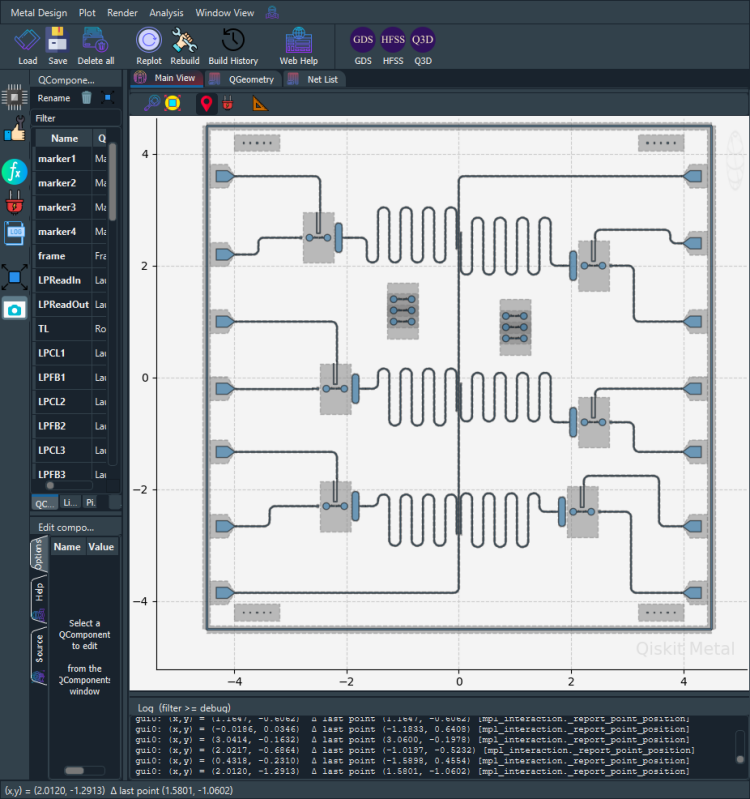

In [20]:
#Save screenshot as a .png formatted file.
gui.screenshot()

In [76]:
gui.main_window.close()

True

# The Maxwell Capacitance Matrix-LOM

## 1. Calculation of Charging Energy AKA E_C

In [21]:
from qiskit_metal.analyses.quantization import LOManalysis

c1 = LOManalysis(design, "q3d")
c1.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 15,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': True,
 'solution_order': 'High',
 'solver_type': 'Iterative'}

In [22]:
# for second method. dont run this
# example: update single setting
c1.sim.setup.max_passes = 15
# example: update multiple settings
c1.sim.setup_update(solution_order = 'Medium', auto_increase_solution_order = 'False')

c1.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 15,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': 'False',
 'solution_order': 'Medium',
 'solver_type': 'Iterative'}

In [23]:
c1.sim.run(components=['Q1'], open_terminations=[('Q1', 'charge_line'), ('Q1', 'flux_bias_line'), ('Q1', 'fake_flux_bias_line'), ('Q1', 'readout_line')])
c1.sim.capacitance_matrix

INFO 01:22PM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:22PM [load_ansys_project]: 	Opened Ansys App
INFO 01:22PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 01:22PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/figenyilmaz/Documents/Ansoft/
	Project:   Project90
INFO 01:22PM [connect_design]: No active design found (or error getting active design).
INFO 01:22PM [connect]: 	 Connected to project "Project90". No design detected
INFO 01:22PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
WARNING 01:22PM [connect_setup]: 	No design setup detected.
WARNING 01:22PM [connect_setup]: 	Creating Q3D default setup.
INFO 01:22PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:22PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:22PM [analyze]: Analyzing setup Setup
INFO 01:26PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppDat

,charge_line_Q1,flux_bias_line_Q1,ground_main_plane,pad_bot_Q1,pad_top_Q1,readout_padNline_Q1
charge_line_Q1,22.07887,-0.12377,-21.13236,-0.06982,-0.61360,-0.04762
flux_bias_line_Q1,-0.12377,59.16311,-45.51711,-4.76237,-4.79576,-2.22450
ground_main_plane,-21.13236,-45.51711,347.01194,-21.90210,-25.71944,-166.36874
pad_bot_Q1,-0.06982,-4.76237,-21.90210,36.94983,-3.48528,-5.50516
pad_top_Q1,-0.61360,-4.79576,-25.71944,-3.48528,36.90831,-1.04654
readout_padNline_Q1,-0.04762,-2.22450,-166.36874,-5.50516,-1.04654,177.50199


In [24]:
# capacitance with pocket-height=650um

Cpad_top = 25.71
Cpad_bot = 21.90
Creadout_bot = 5.505
Creadout_top = 1.046
Ccharge_top = 0.613
Cfluxpad_top = 4.795
Cfluxpad_bot = 4.762

C_pads = 3.4852

C_top = Cpad_top + Ccharge_top + Cfluxpad_top + Creadout_top
C_bot = Cpad_bot + Creadout_bot + Cfluxpad_bot

Csigma = C_pads + C_top*C_bot/(C_top+C_bot)
print('Ctop:', C_top, 'fF')
print('Cbot:', C_bot, 'fF')
print('Total Capacitance:', Csigma, 'fF')

Ctop: 32.164 fF
Cbot: 32.166999999999994 fF
Total Capacitance: 19.56794996502464 fF


In [25]:
import numpy as np
e = 1.60217663e-19
hbar = 1.05457182e-34

Ec = e**2/(2*Csigma*1e-15)
Charging_energy = 1e-6*Ec/(2*np.pi*hbar)
print('Charging Energy:', Charging_energy, 'MHz')
print('E_c:', Ec, '...')

Charging Energy: 989.8956824463696 MHz
E_c: 6.559118247711965e-25 ...


## Ansys QRenderer
How to Render a Metal Design into Ansys

!!!Make sure the programm is ready completly.

In [26]:
from qiskit_metal.renderers.renderer_ansys.ansys_renderer import QAnsysRenderer
QAnsysRenderer.default_options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.2,
 'y_buffer_width_mm': 0.2,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [12]:
hfss.open_ansys()

In [27]:
hfss.connect_ansys()

INFO 01:39PM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:39PM [load_ansys_project]: 	Opened Ansys App
INFO 01:39PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 01:39PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/figenyilmaz/Documents/Ansoft/
	Project:   Project90
INFO 01:39PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 01:39PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:39PM [connect]: 	Connected to project "Project90" and design "Design_q3d" 😀 



In [28]:
hfss.activate_eigenmode_design("cavity1")

01:43PM 58s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
01:43PM 58s WARNING [activate_ansys_design]: The design_name=cavity1 was not in active project.  Designs in active project are: 
['Design_q3d'].  A new design will be added to the project.  
INFO 01:44PM [connect_design]: 	Opened active design
	Design:    cavity1 [Solution type: Eigenmode]
WARNING 01:44PM [connect_setup]: 	No design setup detected.
WARNING 01:44PM [connect_setup]: 	Creating eigenmode default setup.
INFO 01:44PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [29]:
hfss.render_design(['cavity1'], [('cavity1', 'end'), ('cavity1', 'start')])

In [30]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
# pinfo.design.set_variable('Lj', '34.38 nH')
# pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 01:44PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


01:48PM 58s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


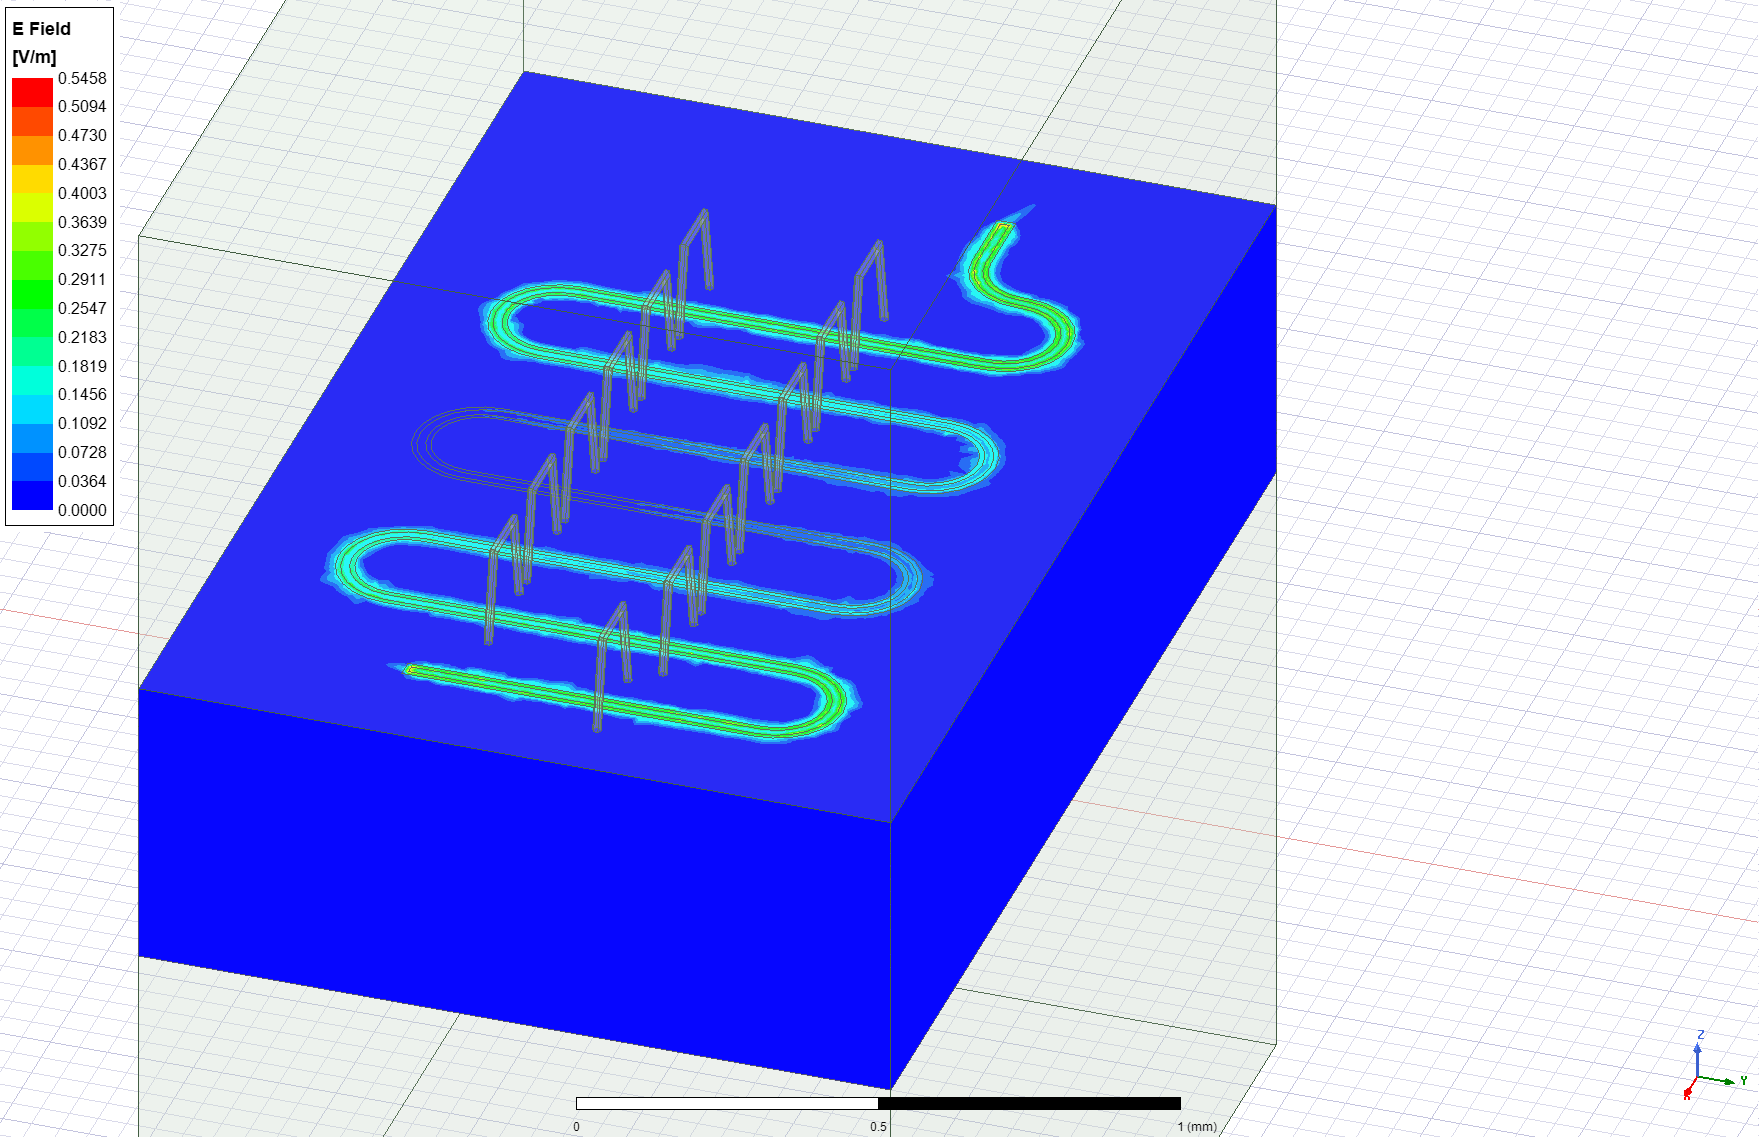

WindowsPath('C:/Users/figenyilmaz/Desktop/GitLab/qiskit-metal/Fluxonium Design/ansys.png')

In [31]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [32]:
hfss.epr_get_frequencies()

Design "cavity1" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,8.010585,inf


In [18]:
hfss.activate_eigenmode_design("cavity6")

08:46PM 51s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
08:46PM 51s WARNING [activate_ansys_design]: The design_name=cavity6 was not in active project.  Designs in active project are: 
['cavity1', 'Design_q3d', 'Q1_Res1'].  A new design will be added to the project.  
INFO 08:46PM [connect_design]: 	Opened active design
	Design:    cavity6 [Solution type: Eigenmode]
WARNING 08:46PM [connect_setup]: 	No design setup detected.
WARNING 08:46PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:46PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [19]:
hfss.render_design(['cavity6'], [('cavity6', 'end'), ('cavity6', 'start')])

In [20]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
#pinfo.design.set_variable('Lj', '10 nH')
#pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 08:46PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


08:49PM 45s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


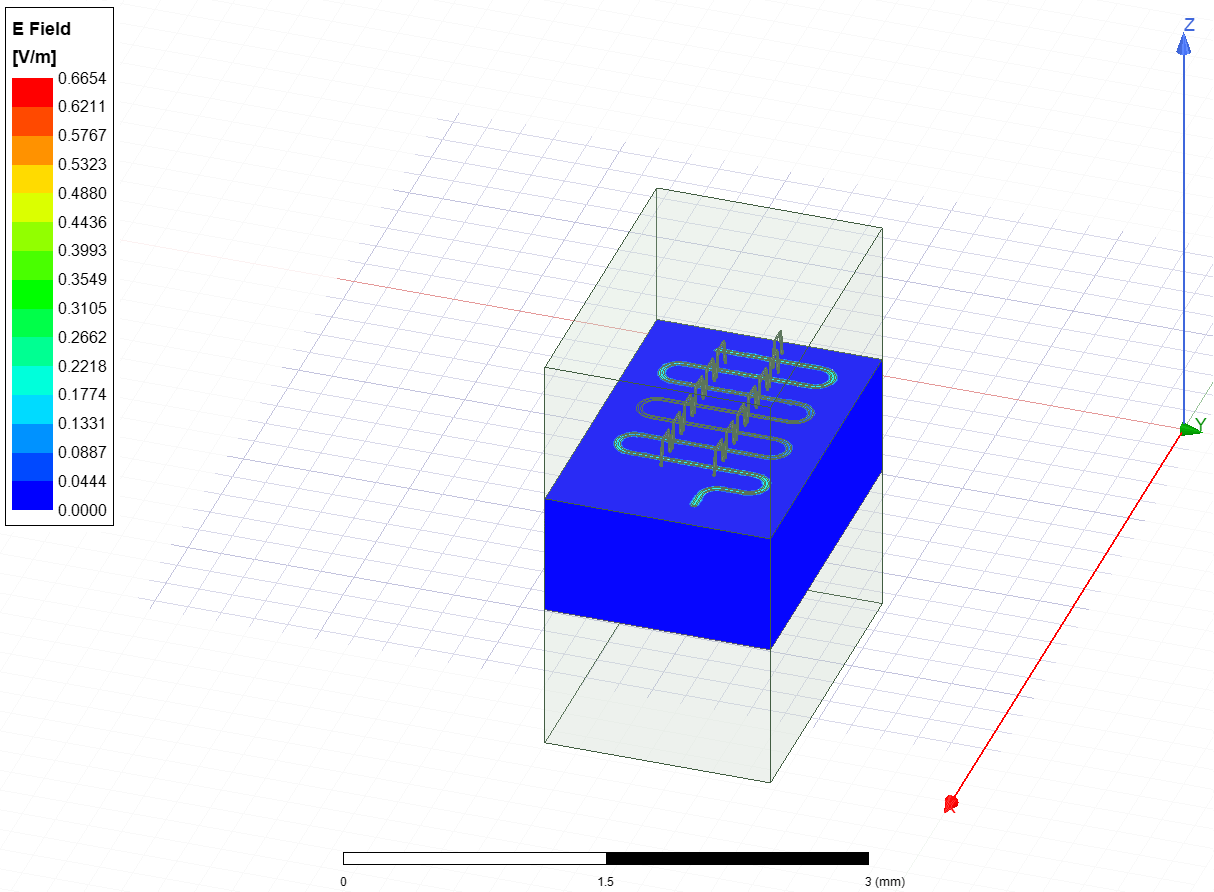

WindowsPath('C:/Users/figenyilmaz/Desktop/qiskit-metal/tutorials_ME/Figen/Fluxonium/GDS-DR/ansys.png')

In [21]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [22]:
hfss.epr_get_frequencies()

Design "cavity6" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,7.591935,inf


In [23]:
hfss.activate_eigenmode_design("cavity2")

08:50PM 23s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
08:50PM 23s WARNING [activate_ansys_design]: The design_name=cavity2 was not in active project.  Designs in active project are: 
['cavity1', 'Design_q3d', 'Q1_Res1', 'cavity6'].  A new design will be added to the project.  
INFO 08:50PM [connect_design]: 	Opened active design
	Design:    cavity2 [Solution type: Eigenmode]
WARNING 08:50PM [connect_setup]: 	No design setup detected.
WARNING 08:50PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:50PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [24]:
hfss.render_design(['cavity2'], [('cavity2', 'end'), ('cavity2', 'start')])

In [25]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
setup.analyze()

hfss.plot_convergences()

INFO 08:50PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


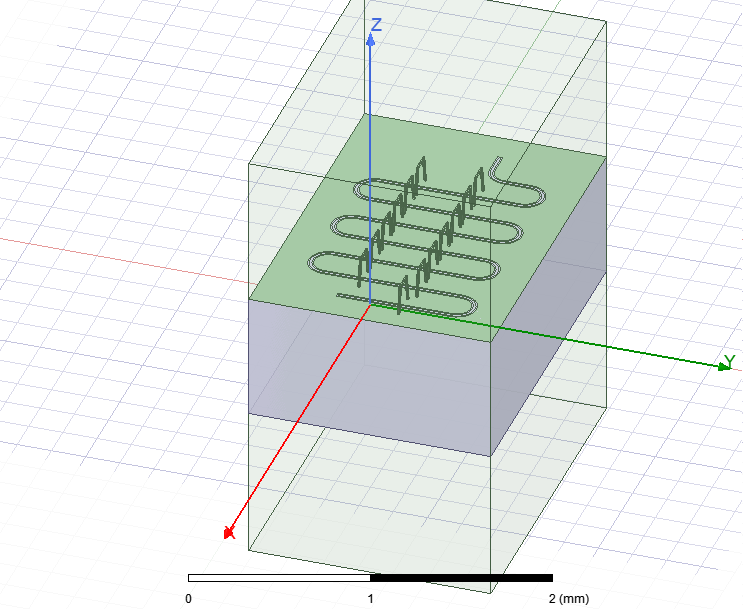

WindowsPath('C:/Users/figenyilmaz/GitLab/qiskit-metal/Fluxonium Designs/ansys.png')

In [26]:
hfss.save_screenshot()

08:52PM 42s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


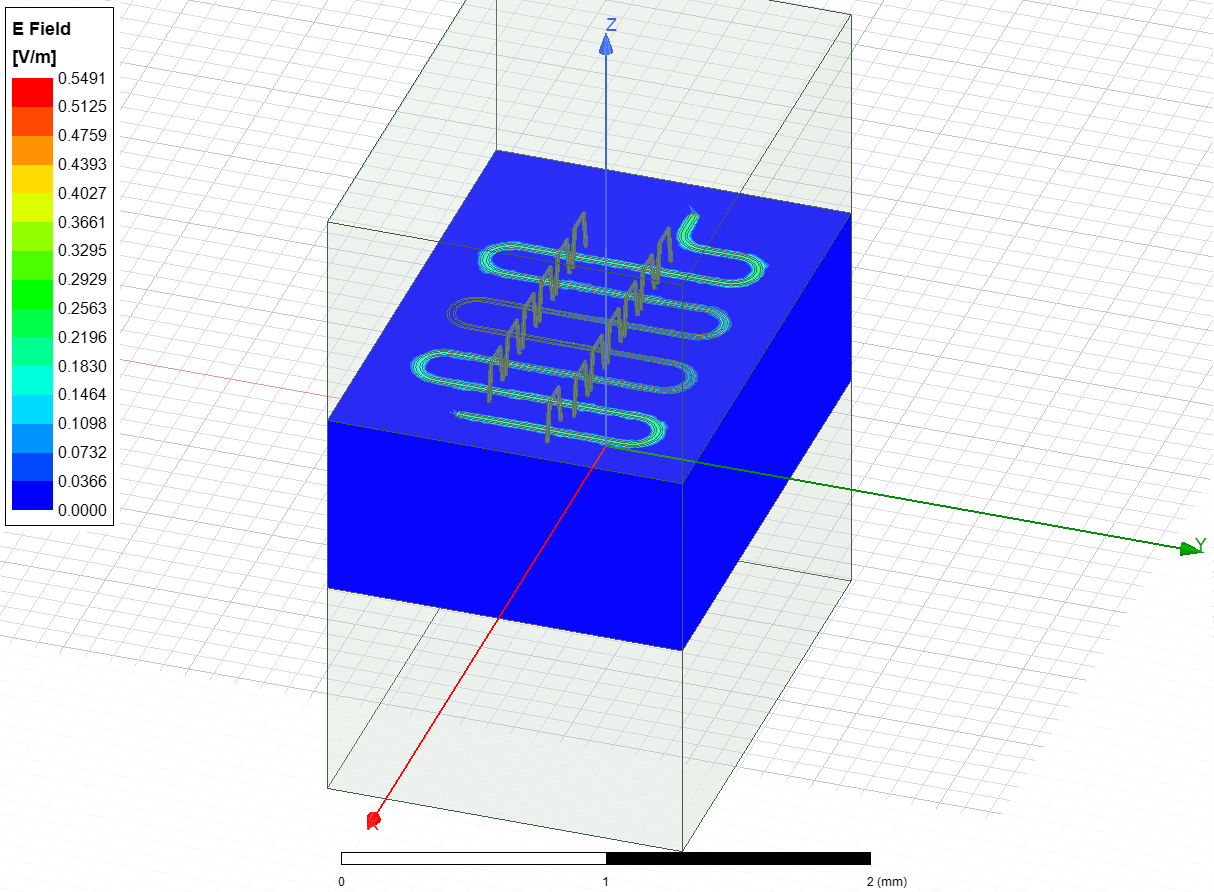

WindowsPath('C:/Users/figenyilmaz/Desktop/qiskit-metal/tutorials_ME/Figen/Fluxonium/GDS-DR/ansys.png')

In [26]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [27]:
hfss.epr_get_frequencies()

Design "cavity2" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,7.211648,inf


In [35]:
hfss.activate_eigenmode_design("cavity5")

08:58PM 38s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
08:58PM 38s WARNING [activate_ansys_design]: The design_name=cavity5-2 was not in active project.  Designs in active project are: 
['cavity1', 'Design_q3d', 'cavity2', 'Q1_Res1', 'cavity6', 'cavity5'].  A new design will be added to the project.  
INFO 08:58PM [connect_design]: 	Opened active design
	Design:    cavity5-2 [Solution type: Eigenmode]
WARNING 08:58PM [connect_setup]: 	No design setup detected.
WARNING 08:58PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:58PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [36]:
hfss.render_design(['cavity5'], [('cavity5', 'end'), ('cavity5', 'start')])

In [37]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
setup.analyze()

hfss.plot_convergences()

INFO 08:58PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


09:00PM 33s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


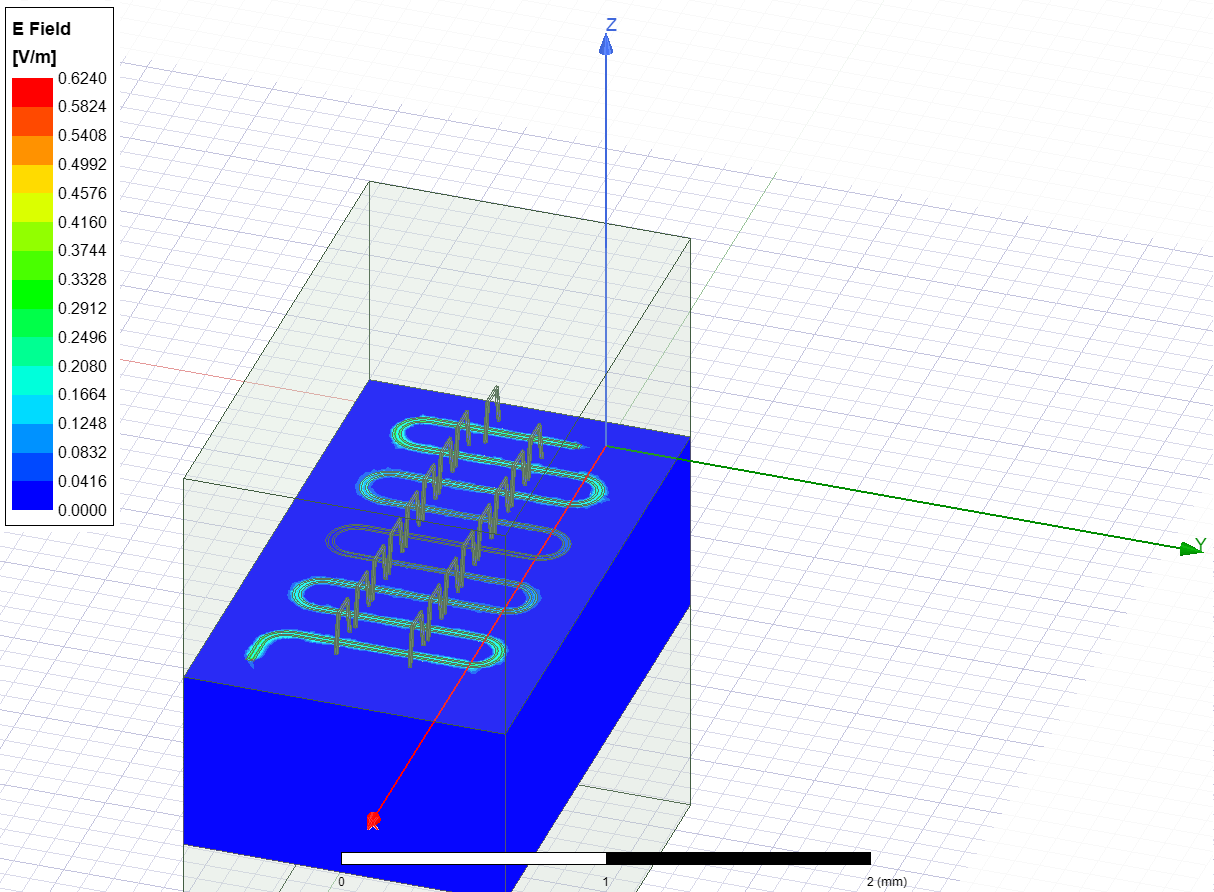

WindowsPath('C:/Users/figenyilmaz/Desktop/qiskit-metal/tutorials_ME/Figen/Fluxonium/GDS-DR/ansys.png')

In [38]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [39]:
hfss.epr_get_frequencies()

Design "cavity5-2" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,6.796478,inf


In [40]:
hfss.activate_eigenmode_design("cavity3")

09:01PM 16s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
09:01PM 16s WARNING [activate_ansys_design]: The design_name=cavity3 was not in active project.  Designs in active project are: 
['cavity1', 'Design_q3d', 'cavity2', 'Q1_Res1', 'cavity6', 'cavity5-2', 'cavity5'].  A new design will be added to the project.  
INFO 09:01PM [connect_design]: 	Opened active design
	Design:    cavity3 [Solution type: Eigenmode]
WARNING 09:01PM [connect_setup]: 	No design setup detected.
WARNING 09:01PM [connect_setup]: 	Creating eigenmode default setup.
INFO 09:01PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [41]:
hfss.render_design(['cavity3'], [('cavity3', 'end'), ('cavity3', 'start')])

In [42]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
#pinfo.design.set_variable('Lj', '10 nH')
#pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 09:01PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


09:03PM 14s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


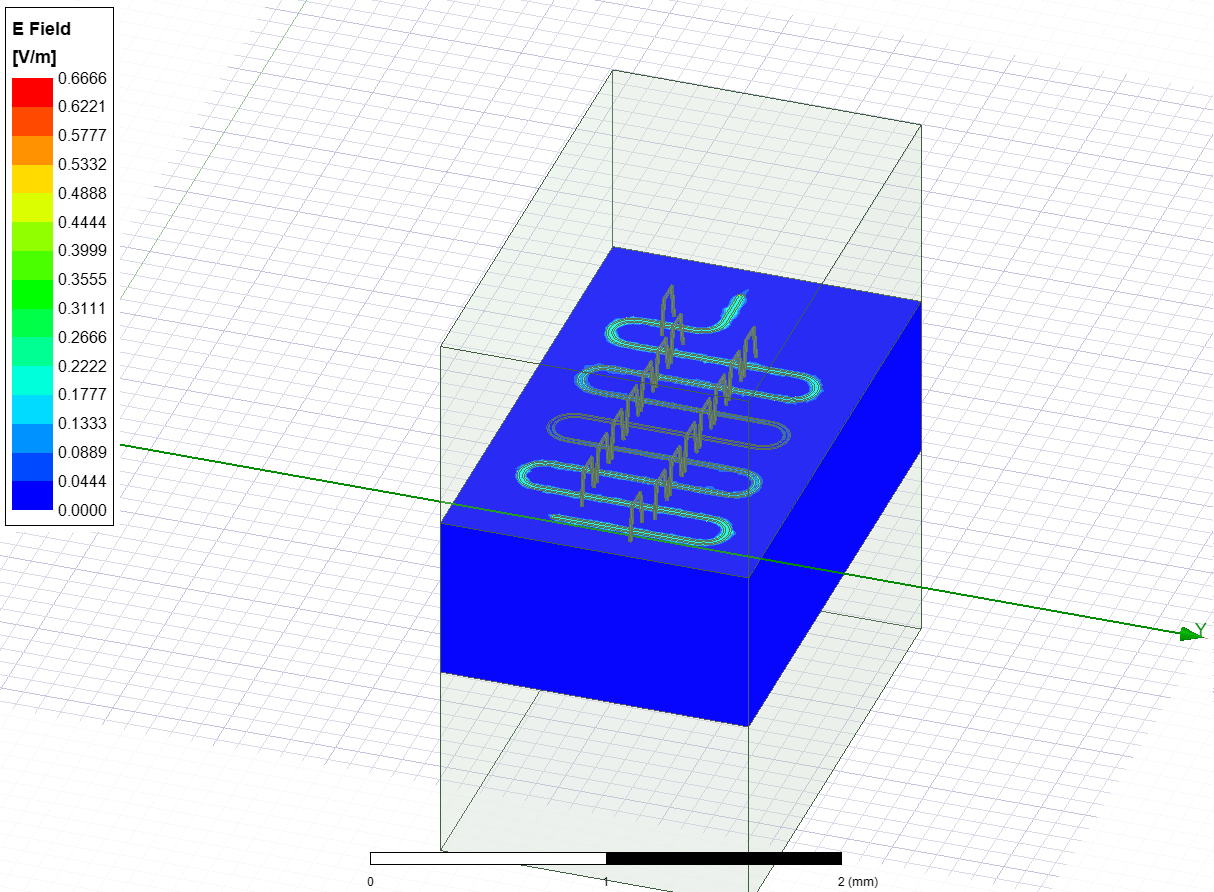

WindowsPath('C:/Users/figenyilmaz/Desktop/qiskit-metal/tutorials_ME/Figen/Fluxonium/GDS-DR/ansys.png')

In [43]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [44]:
hfss.epr_get_frequencies()

Design "cavity3" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,6.394962,inf


In [51]:
hfss.activate_eigenmode_design("cavity4")

09:09PM 15s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
09:09PM 15s WARNING [activate_ansys_design]: The design_name=cavity4-2 was not in active project.  Designs in active project are: 
['cavity1', 'Design_q3d', 'cavity2', 'Q1_Res1', 'cavity6', 'cavity3', 'cavity5-2', 'cavity5', 'cavity4'].  A new design will be added to the project.  
INFO 09:09PM [connect_design]: 	Opened active design
	Design:    cavity4-2 [Solution type: Eigenmode]
WARNING 09:09PM [connect_setup]: 	No design setup detected.
WARNING 09:09PM [connect_setup]: 	Creating eigenmode default setup.
INFO 09:09PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [52]:
hfss.render_design(['cavity4'], [('cavity4', 'end'), ('cavity4', 'start')])

In [53]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
setup.analyze()

hfss.plot_convergences()

INFO 09:09PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


09:12PM 06s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


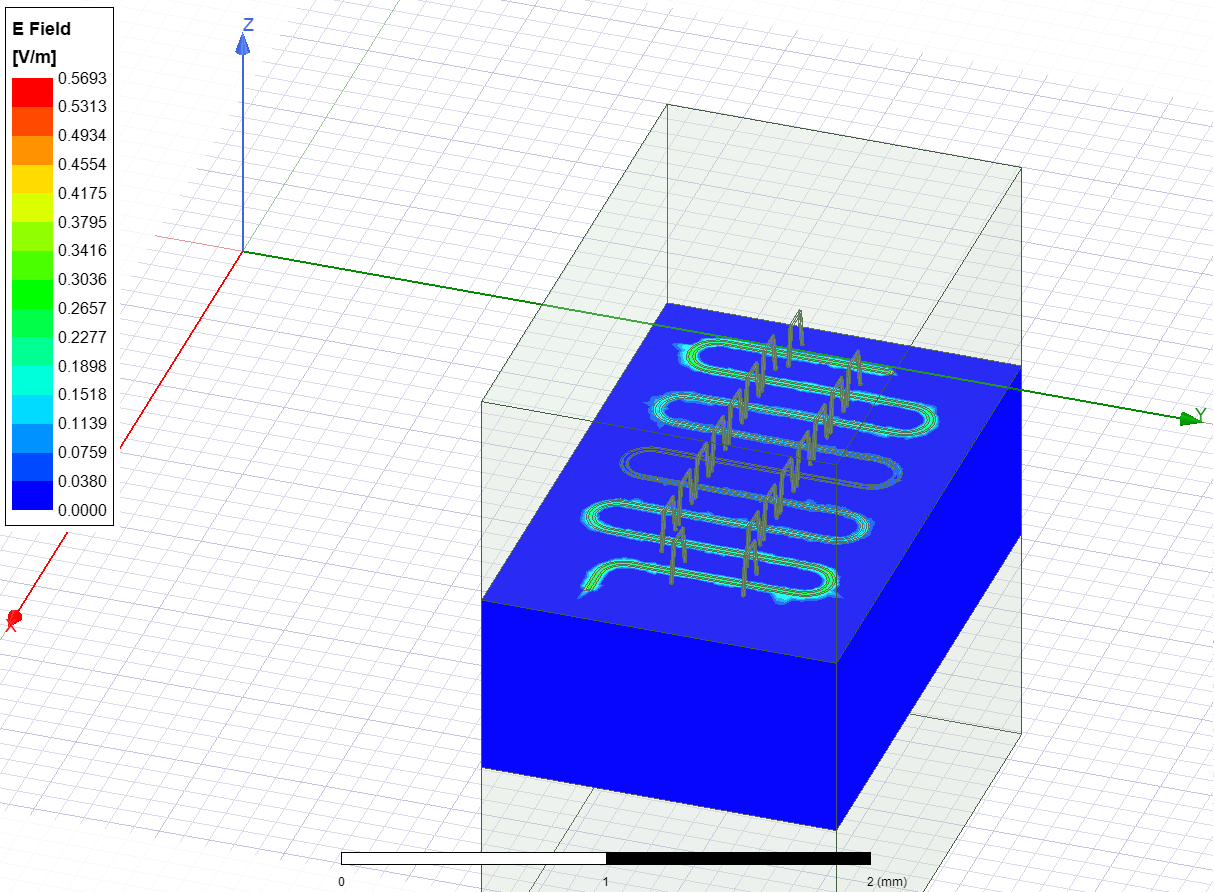

WindowsPath('C:/Users/figenyilmaz/Desktop/qiskit-metal/tutorials_ME/Figen/Fluxonium/GDS-DR/ansys.png')

In [54]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [55]:
hfss.epr_get_frequencies()

Design "cavity4-2" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,6.02932,inf


In [56]:
QAnsysRenderer.get_template_options(design)

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.2,
 'y_buffer_width_mm': 0.2,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [57]:
QAnsysRenderer.default_setup

{'drivenmodal': {'name': 'Setup',
  'freq_ghz': '5.0',
  'max_delta_s': '0.1',
  'max_passes': '10',
  'min_passes': '1',
  'min_converged': '1',
  'pct_refinement': '30',
  'basis_order': '1'},
 'eigenmode': {'name': 'Setup',
  'min_freq_ghz': '1',
  'n_modes': '1',
  'max_delta_f': '0.5',
  'max_passes': '10',
  'min_passes': '1',
  'min_converged': '1',
  'pct_refinement': '30',
  'basis_order': '-1'},
 'q3d': {'name': 'Setup',
  'freq_ghz': '5.0',
  'save_fields': 'False',
  'enabled': 'True',
  'max_passes': '15',
  'min_passes': '2',
  'min_converged_passes': '2',
  'percent_error': '0.5',
  'percent_refinement': '30',
  'auto_increase_solution_order': 'True',
  'solution_order': 'High',
  'solver_type': 'Iterative'},
 'port_inductor_gap': '10um'}

In [63]:
hfss.disconnect_ansys()

Warning! 3 COM references still alive
Ansys will likely refuse to shut down


In [33]:
hfss.clean_active_design()

In [34]:
hfss.activate_eigenmode_design("Q1_Res1")

01:52PM 33s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
01:52PM 33s WARNING [activate_ansys_design]: The design_name=Q1_Res1 was not in active project.  Designs in active project are: 
['Design_q3d', 'cavity1'].  A new design will be added to the project.  
INFO 01:52PM [connect_design]: 	Opened active design
	Design:    Q1_Res1 [Solution type: Eigenmode]
WARNING 01:52PM [connect_setup]: 	No design setup detected.
WARNING 01:52PM [connect_setup]: 	Creating eigenmode default setup.
INFO 01:52PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [35]:
hfss.options['x_buffer_width_mm'] = 0.9
hfss.options['y_buffer_width_mm'] = 0.9
hfss.options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.9,
 'y_buffer_width_mm': 0.9,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [36]:
design.qgeometry.tables['junction']

,component,name,geometry,layer,subtract,helper,chip,width,hfss_inductance,hfss_capacitance,hfss_resistance,hfss_mesh_kw_jj,q3d_inductance,q3d_capacitance,q3d_resistance,q3d_mesh_kw_jj,gds_cell_name
0,21,inductor,"LINESTRING (-2.135 -2.282, -2.265 -2.282)",1,False,False,main,0.001,218.823nH,0,0,0.000007,10nH,0,0,0.000007,jj_array0
1,21,rect_jj,"LINESTRING (-2.185 -2.3, -2.215 -2.3)",1,False,False,main,0.008,40.7885nH,0.72fF,0,0.000007,10nH,0,0,0.000007,junction_0
2,22,inductor,"LINESTRING (2.265 -2.382, 2.135 -2.382)",1,False,False,main,0.001,218.823nH,0,0,0.000007,10nH,0,0,0.000007,jj_array0
3,22,rect_jj,"LINESTRING (2.215 -2.4, 2.185 -2.4)",1,False,False,main,0.008,40.7885nH,0.72fF,0,0.000007,10nH,0,0,0.000007,junction_0
4,23,inductor,"LINESTRING (-2.135 -0.182, -2.265 -0.182)",1,False,False,main,0.001,218.823nH,0,0,0.000007,10nH,0,0,0.000007,jj_array0
5,23,rect_jj,"LINESTRING (-2.185 -0.2, -2.215 -0.2)",1,False,False,main,0.008,40.7885nH,0.72fF,0,0.000007,10nH,0,0,0.000007,junction_0
6,24,inductor,"LINESTRING (2.465 -0.782, 2.335 -0.782)",1,False,False,main,0.001,218.823nH,0,0,0.000007,10nH,0,0,0.000007,jj_array0
7,24,rect_jj,"LINESTRING (2.415 -0.8, 2.385 -0.8)",1,False,False,main,0.008,40.7885nH,0.72fF,0,0.000007,10nH,0,0,0.000007,junction_0
8,25,inductor,"LINESTRING (-2.435 2.518, -2.565 2.518)",1,False,False,main,0.001,218.823nH,0,0,0.000007,10nH,0,0,0.000007,jj_array0
9,25,rect_jj,"LINESTRING (-2.485 2.5, -2.515 2.5)",1,False,False,main,0.008,40.7885nH,0.72fF,0,0.000007,10nH,0,0,0.000007,junction_0


In [37]:
hfss.render_design(['Q1', 'cavity1', 'otg1s'],[('cavity1', 'end')])

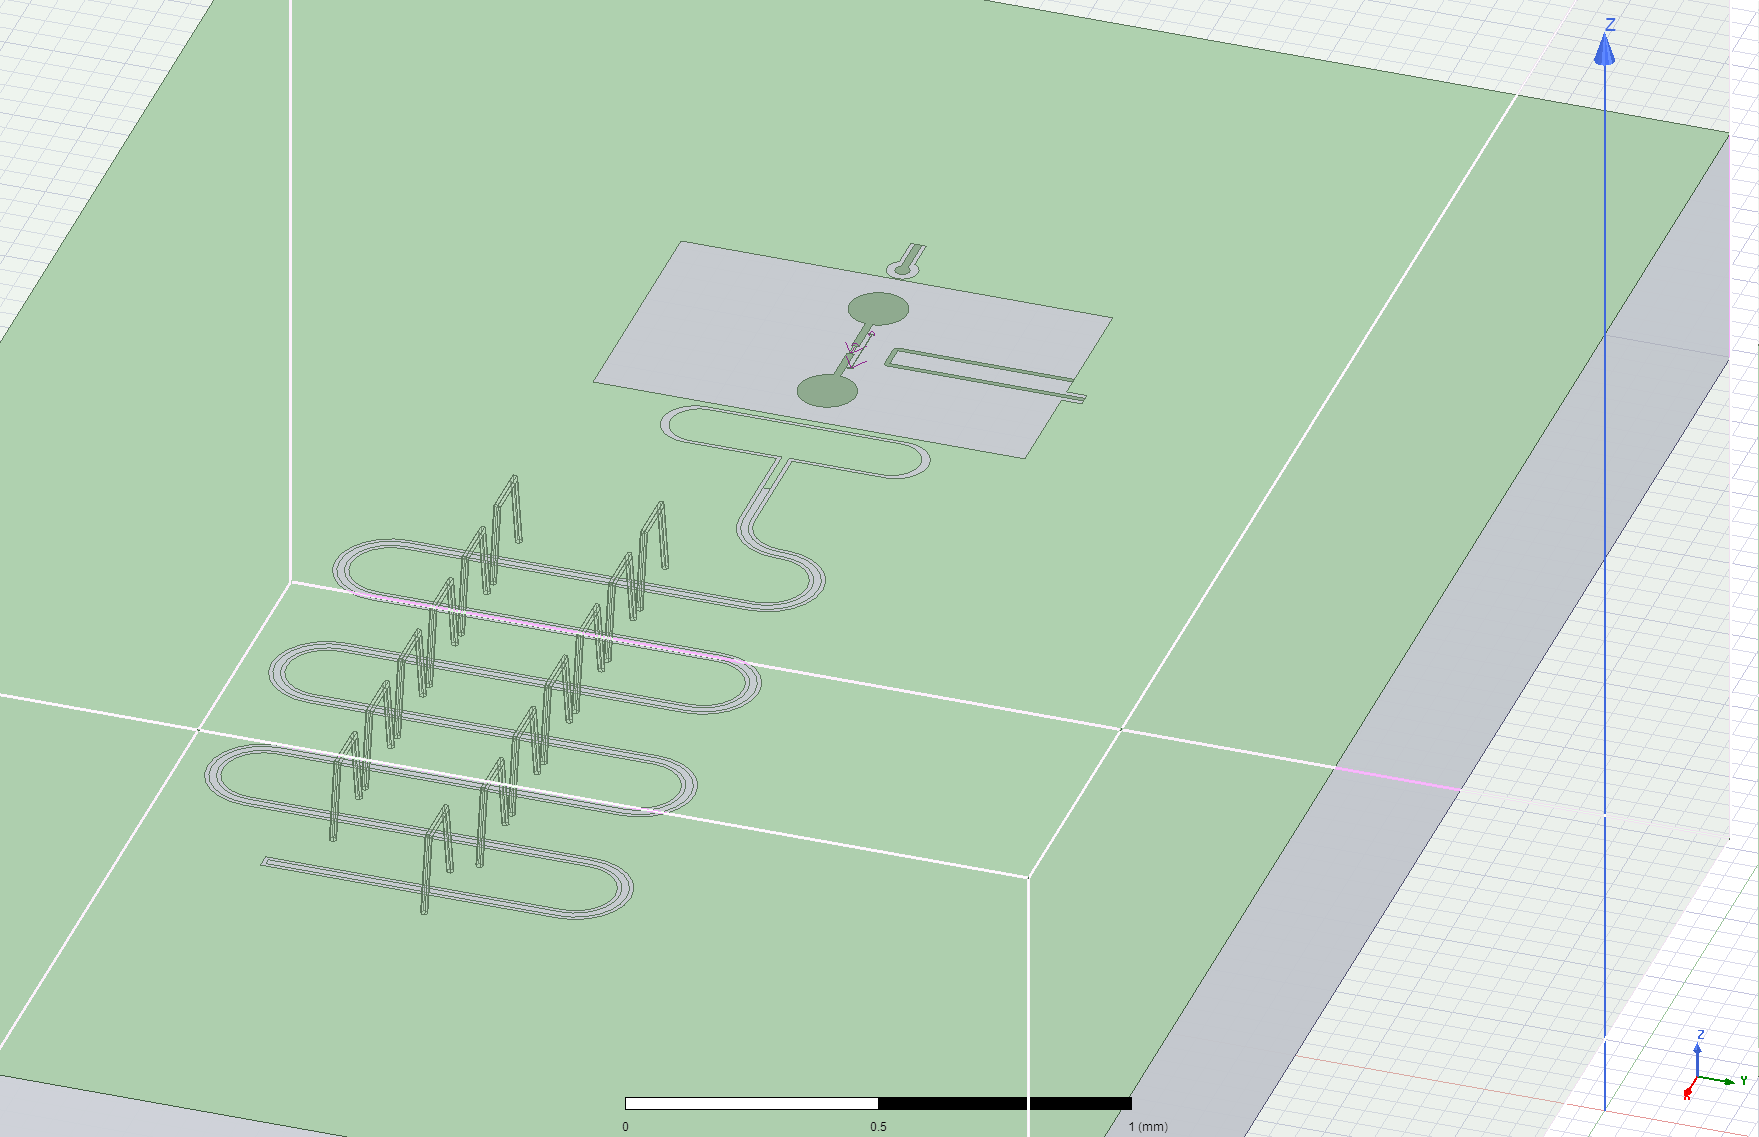

WindowsPath('C:/Users/figenyilmaz/Desktop/GitLab/qiskit-metal/Fluxonium Design/ansys.png')

In [38]:
hfss.save_screenshot()

In [39]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 15
#setup.delta_f = 0.05
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '34.38 nH') #targetted EJ/2pi=4.75 GHz
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 01:53PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 2
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


02:28PM 22s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


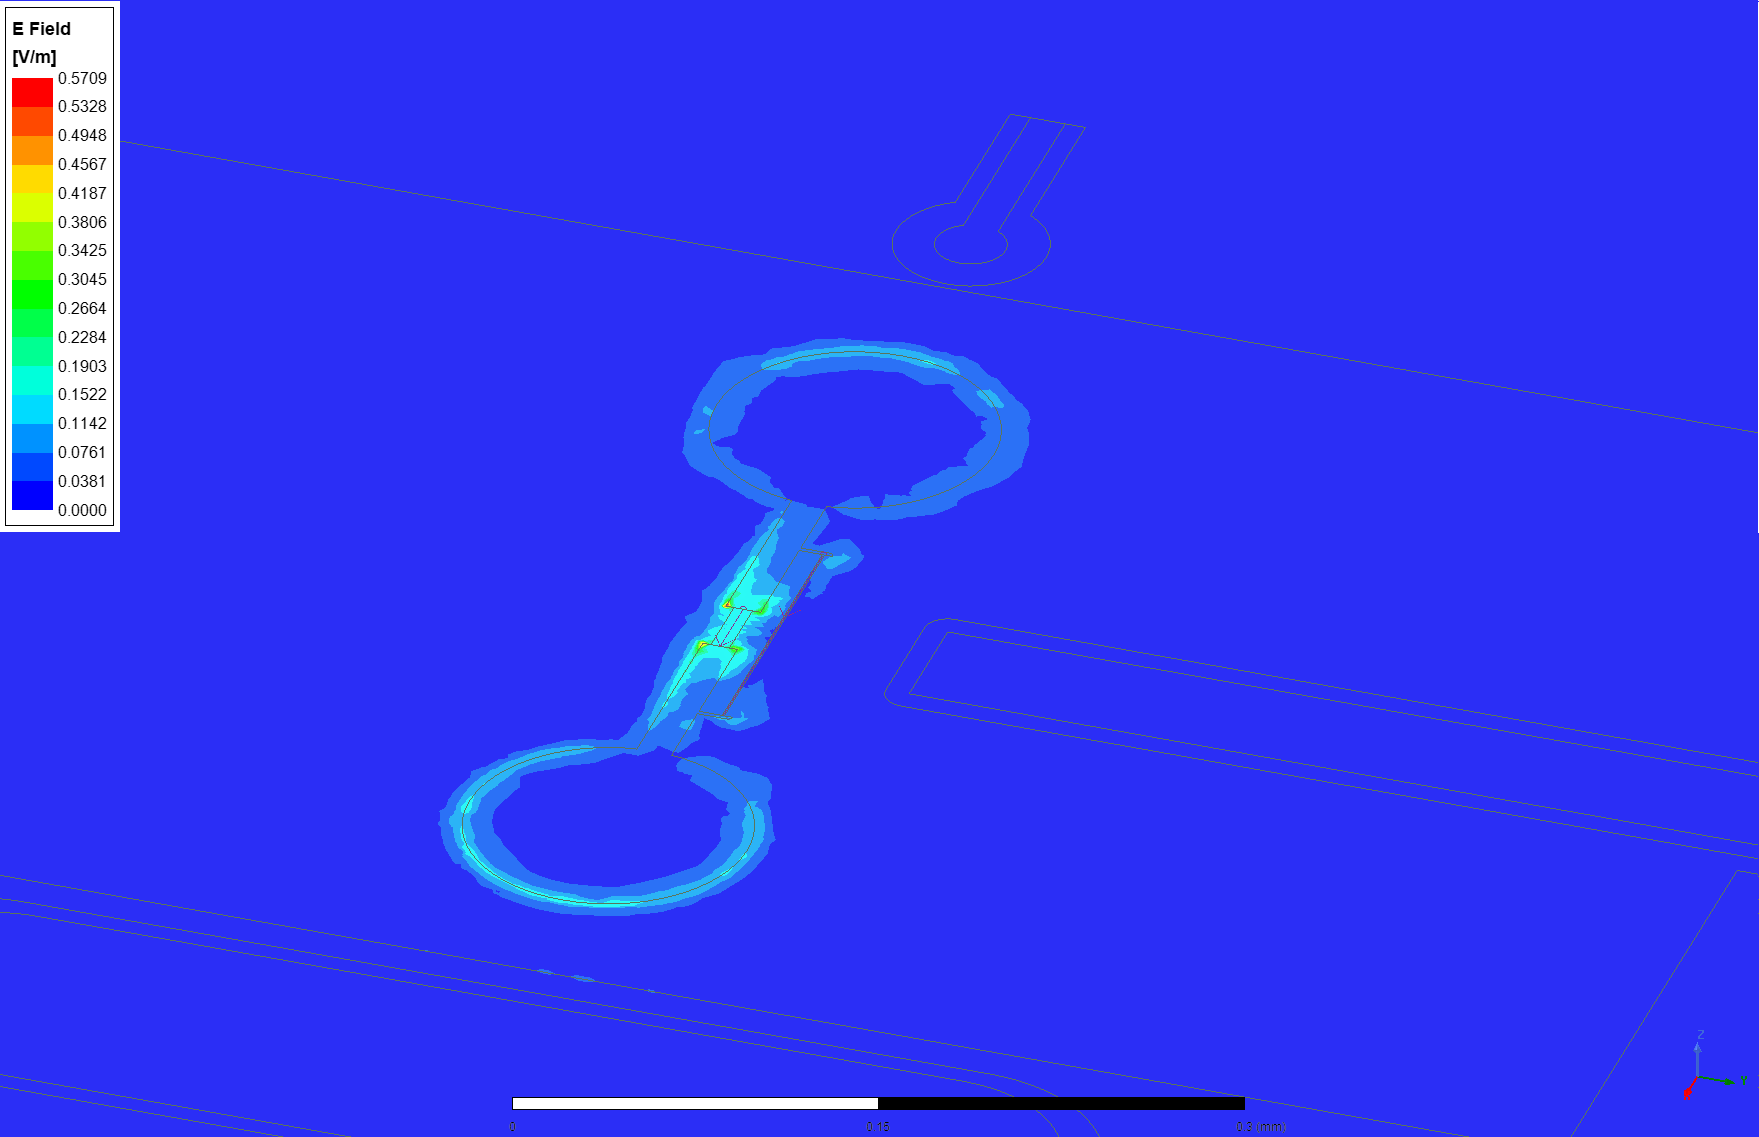

WindowsPath('C:/Users/figenyilmaz/Desktop/GitLab/qiskit-metal/Fluxonium Design/ansys.png')

In [41]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [72]:
hfss.plot_ansys_delete(['Mag_E1'])

02:55PM 22s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [73]:
hfss.set_mode(2, "Setup")

INFO 02:55PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


02:55PM 26s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


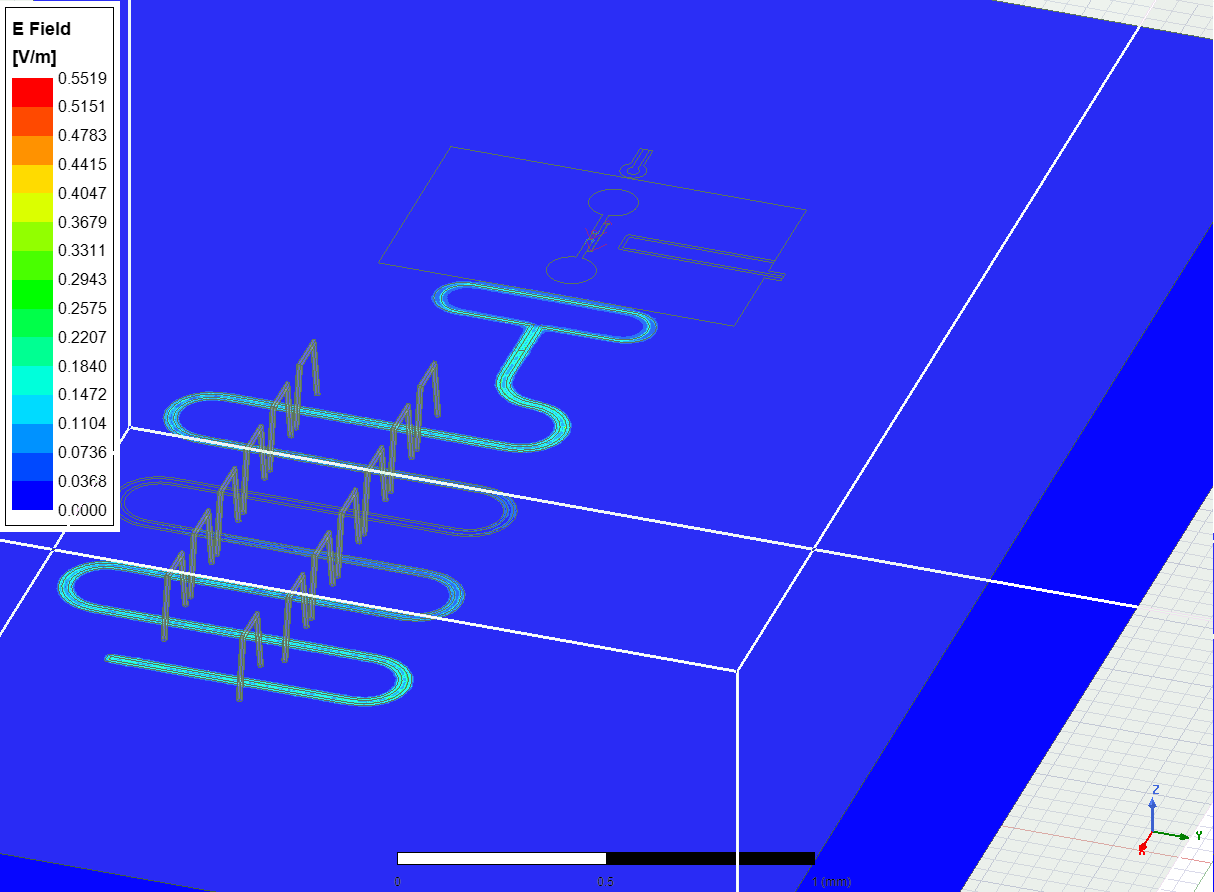

WindowsPath('C:/Users/figenyilmaz/Desktop/qiskit-metal/tutorials_ME/Figen/Fluxonium/GDS-DR/ansys.png')

In [74]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [75]:
hfss.plot_ansys_delete(['Mag_E1'])

02:55PM 44s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [76]:
hfss.epr_get_frequencies()

Design "Q1_Res1" info:
	# eigenmodes    2
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        6.357910             inf
          1        7.074363             inf

In [77]:
hfss.clean_active_design()

In [78]:
hfss.activate_eigenmode_design("Q2_Res2")

02:56PM 41s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
02:56PM 41s WARNING [activate_ansys_design]: The design_name=Q2_Res2 was not in active project.  Designs in active project are: 
['Q1_Res1'].  A new design will be added to the project.  
INFO 02:56PM [connect_design]: 	Opened active design
	Design:    Q2_Res2 [Solution type: Eigenmode]
WARNING 02:56PM [connect_setup]: 	No design setup detected.
WARNING 02:56PM [connect_setup]: 	Creating eigenmode default setup.
INFO 02:56PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [79]:
hfss.render_design(['Q2', 'cavity2', 'otg2s'],[('cavity2', 'end')])

In [80]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 15
#setup.delta_f = 0.05
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '34.38 nH') #targetted EJ/2pi=4.75 GHz
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()


Number of eigenmodes to find             = 2
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1



INFO 02:56PM [analyze]: Analyzing setup Setup


This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


03:15PM 53s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


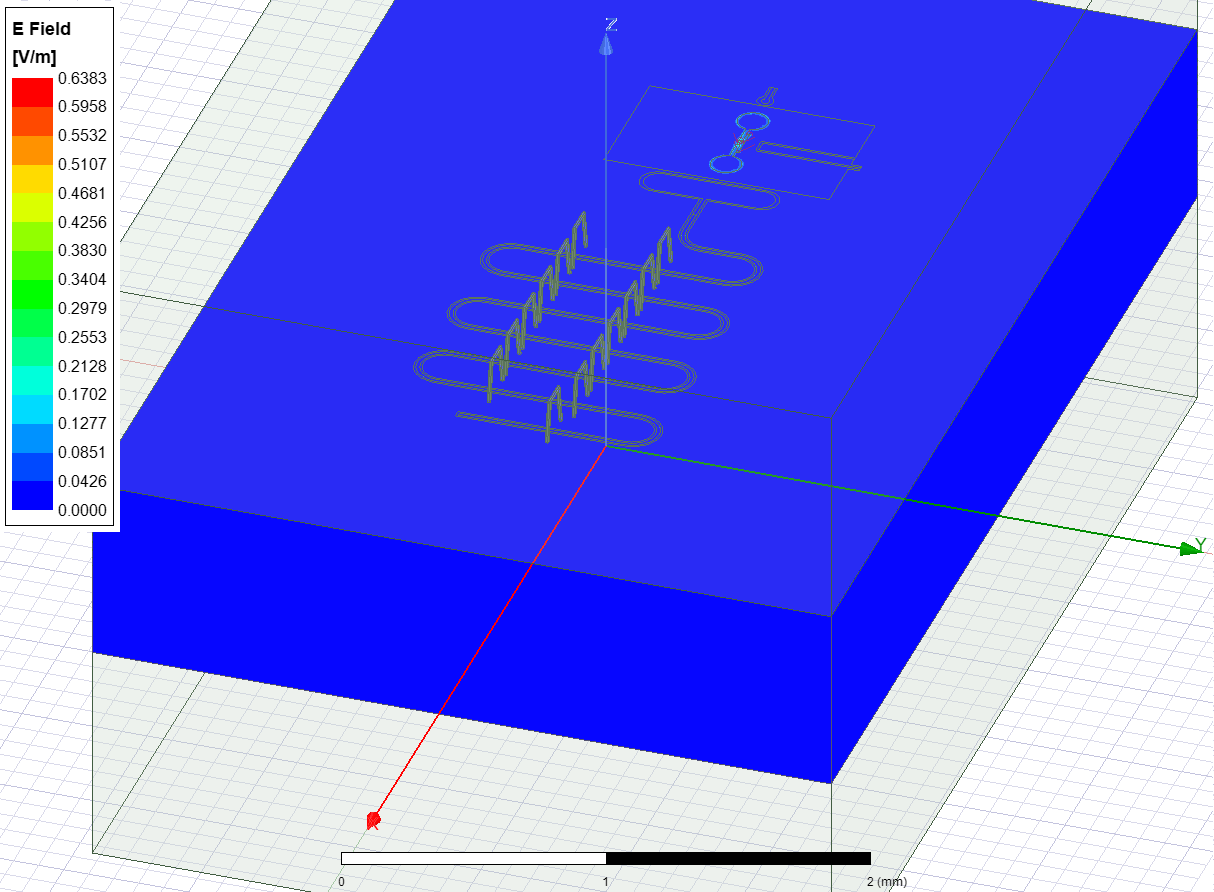

WindowsPath('C:/Users/figenyilmaz/Desktop/qiskit-metal/tutorials_ME/Figen/Fluxonium/GDS-DR/ansys.png')

In [81]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [83]:
hfss.plot_ansys_delete(['Mag_E1'])

03:16PM 38s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [84]:
hfss.set_mode(2, "Setup")

INFO 03:16PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


03:16PM 41s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


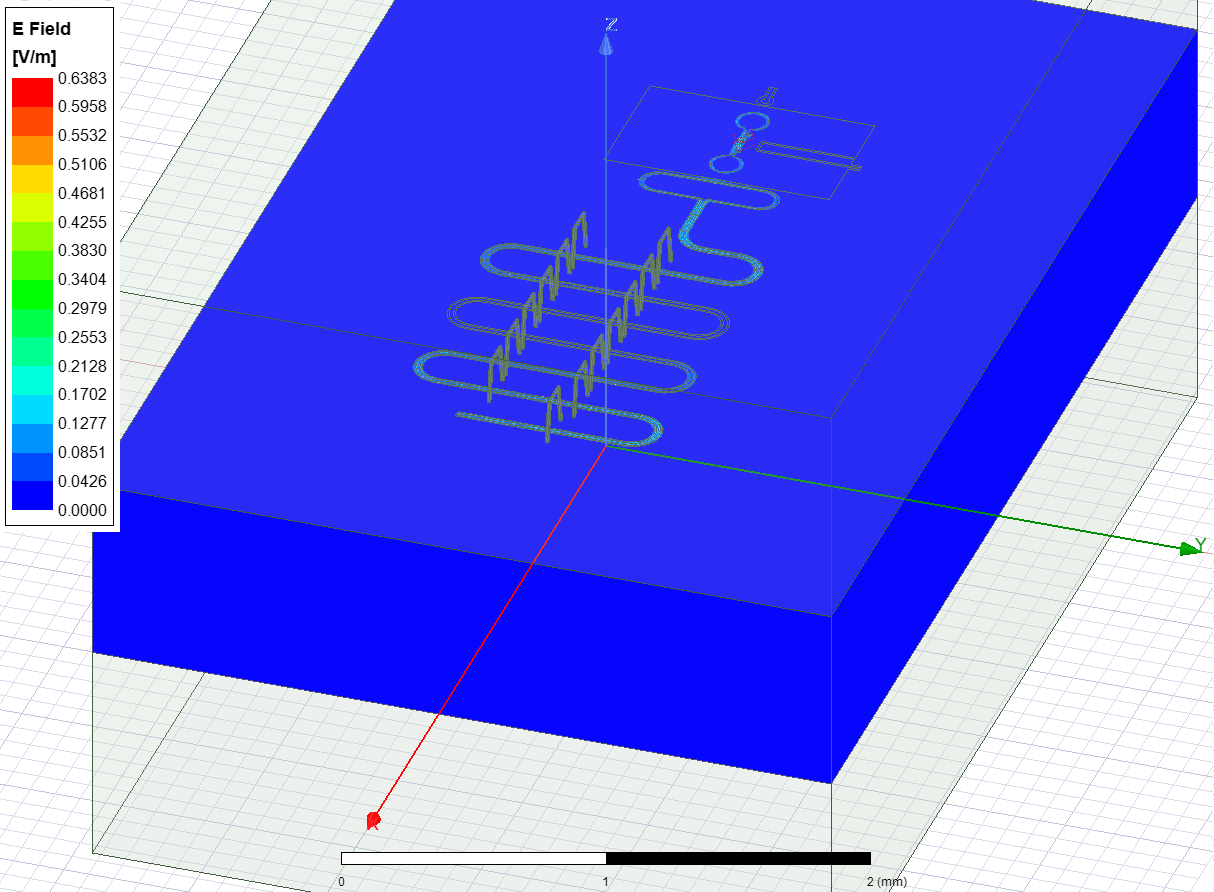

WindowsPath('C:/Users/figenyilmaz/Desktop/qiskit-metal/tutorials_ME/Figen/Fluxonium/GDS-DR/ansys.png')

In [85]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [82]:
hfss.epr_get_frequencies()

Design "Q2_Res2" info:
	# eigenmodes    2
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        6.345441             inf
          1        6.472531             inf

In [86]:
hfss.activate_eigenmode_design("Q3_Res3")

03:18PM 21s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
03:18PM 21s WARNING [activate_ansys_design]: The design_name=Q3_Res3 was not in active project.  Designs in active project are: 
['Q1_Res1', 'Q2_Res2'].  A new design will be added to the project.  
INFO 03:18PM [connect_design]: 	Opened active design
	Design:    Q3_Res3 [Solution type: Eigenmode]
WARNING 03:18PM [connect_setup]: 	No design setup detected.
WARNING 03:18PM [connect_setup]: 	Creating eigenmode default setup.
INFO 03:18PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [87]:
hfss.render_design(['Q3', 'cavity3', 'otg3s'],[('cavity3', 'end')])

In [88]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 15
#setup.delta_f = 0.05
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '34.38 nH') #targetted EJ/2pi=4.75 GHz
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()


Number of eigenmodes to find             = 2
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1



INFO 03:19PM [analyze]: Analyzing setup Setup


This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


03:35PM 00s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


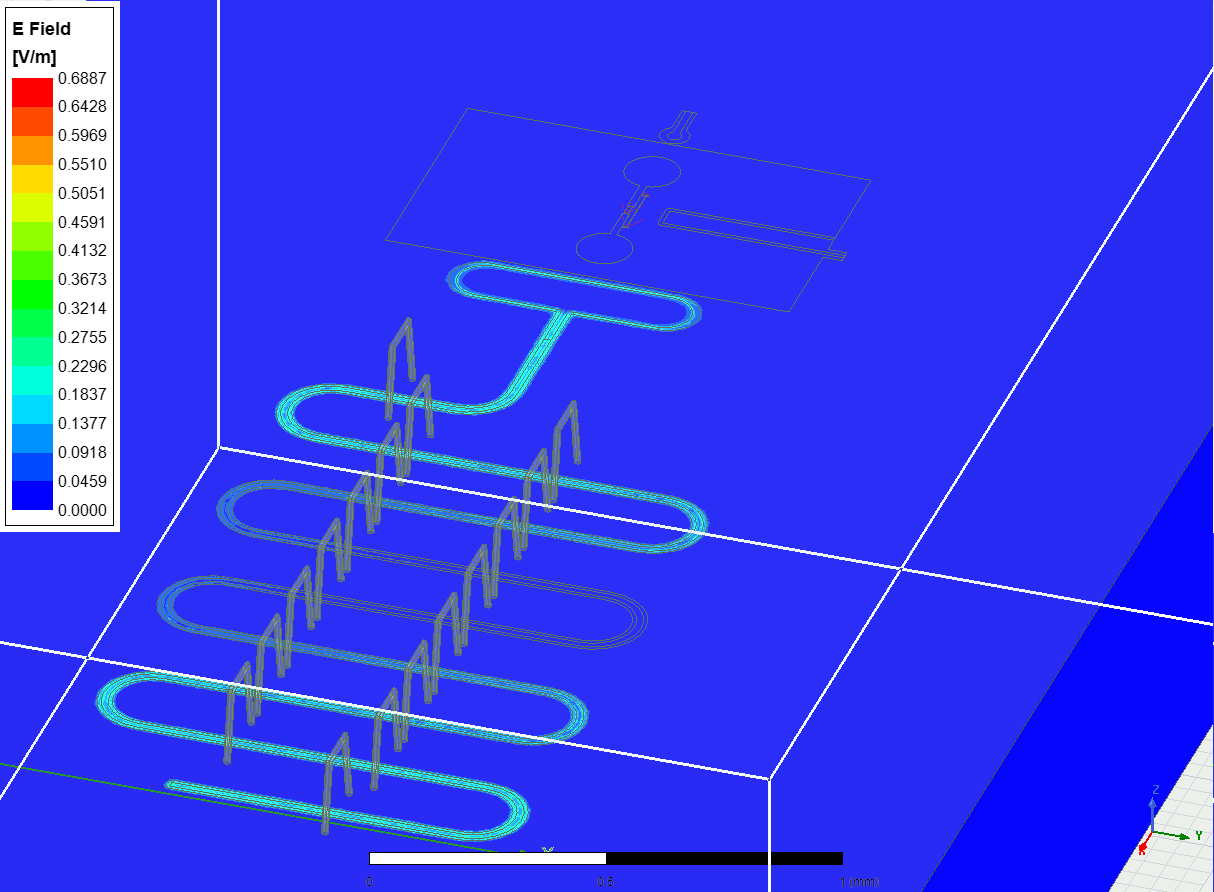

WindowsPath('C:/Users/figenyilmaz/Desktop/qiskit-metal/tutorials_ME/Figen/Fluxonium/GDS-DR/ansys.png')

In [89]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [90]:
hfss.epr_get_frequencies()

Design "Q3_Res3" info:
	# eigenmodes    2
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        5.777802             inf
          1        6.413267             inf

In [91]:
hfss.activate_eigenmode_design("Q4_Res4")

03:35PM 54s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
03:35PM 54s WARNING [activate_ansys_design]: The design_name=Q4_Res4 was not in active project.  Designs in active project are: 
['Q3_Res3', 'Q1_Res1', 'Q2_Res2'].  A new design will be added to the project.  
INFO 03:35PM [connect_design]: 	Opened active design
	Design:    Q4_Res4 [Solution type: Eigenmode]
WARNING 03:35PM [connect_setup]: 	No design setup detected.
WARNING 03:35PM [connect_setup]: 	Creating eigenmode default setup.
INFO 03:35PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [92]:
hfss.render_design(['Q4', 'cavity4', 'otg4s'],[('cavity4', 'end')])

In [93]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 15
#setup.delta_f = 0.05
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '34.38 nH') #targetted EJ/2pi=4.75 GHz
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 03:36PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 2
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


03:49PM 47s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


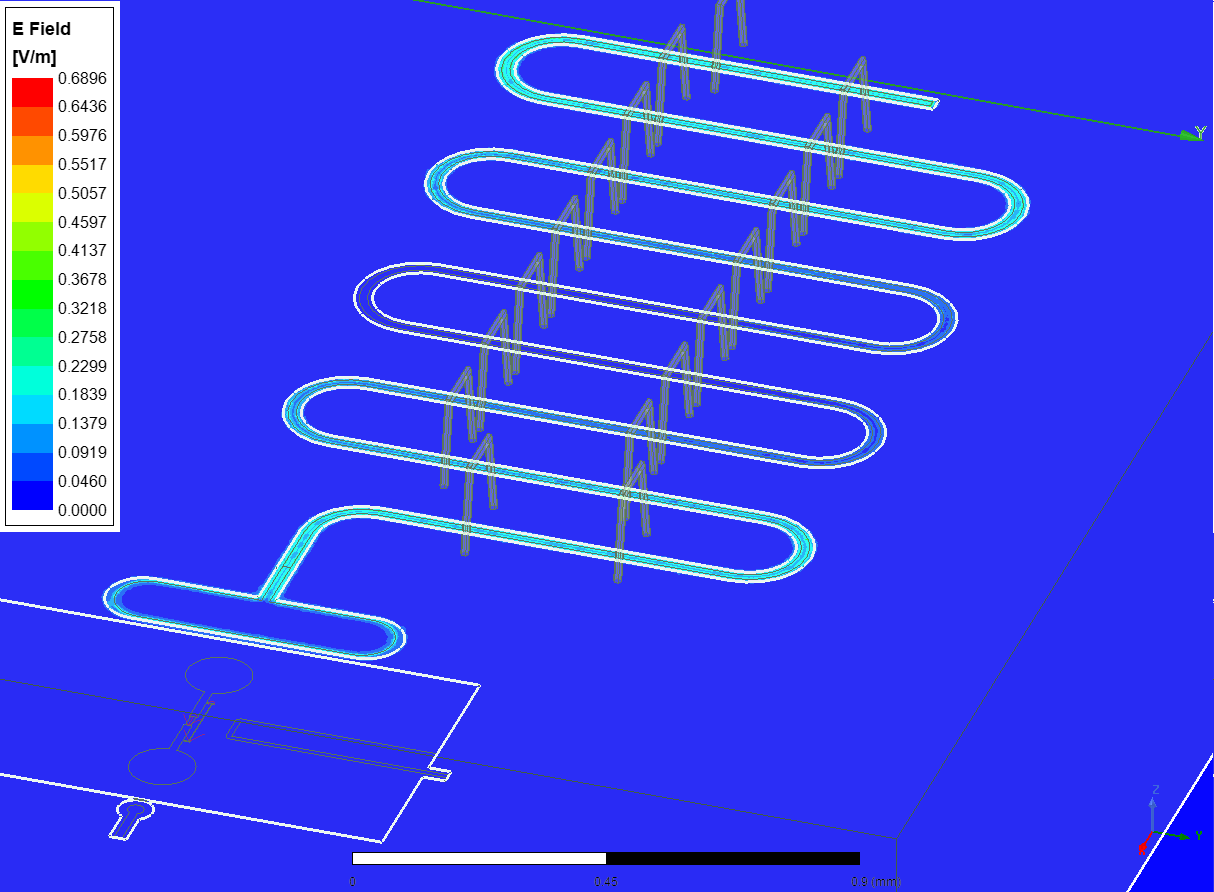

WindowsPath('C:/Users/figenyilmaz/Desktop/qiskit-metal/tutorials_ME/Figen/Fluxonium/GDS-DR/ansys.png')

In [94]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [95]:
hfss.epr_get_frequencies()

Design "Q4_Res4" info:
	# eigenmodes    2
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        5.473703             inf
          1        6.386296             inf

In [96]:
hfss.activate_eigenmode_design("Q5_Res5")

03:50PM 18s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
03:50PM 18s WARNING [activate_ansys_design]: The design_name=Q5_Res5 was not in active project.  Designs in active project are: 
['Q3_Res3', 'Q1_Res1', 'Q2_Res2', 'Q4_Res4'].  A new design will be added to the project.  
INFO 03:50PM [connect_design]: 	Opened active design
	Design:    Q5_Res5 [Solution type: Eigenmode]
WARNING 03:50PM [connect_setup]: 	No design setup detected.
WARNING 03:50PM [connect_setup]: 	Creating eigenmode default setup.
INFO 03:50PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [97]:
hfss.render_design(['Q5', 'cavity5', 'otg5s'],[('cavity5', 'end')])

In [98]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 15
#setup.delta_f = 0.05
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '34.38 nH') #targetted EJ/2pi=4.75 GHz
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 03:50PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 2
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


04:02PM 45s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


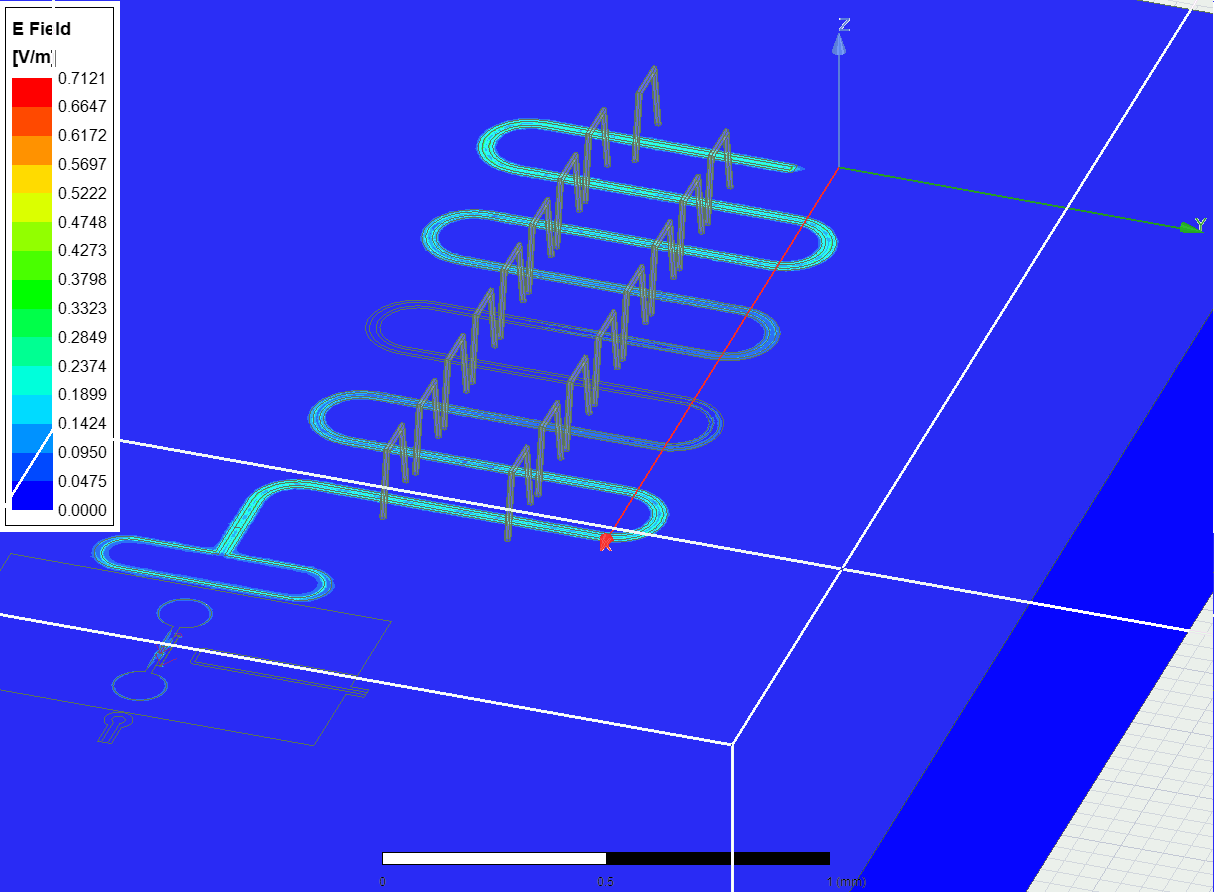

WindowsPath('C:/Users/figenyilmaz/Desktop/qiskit-metal/tutorials_ME/Figen/Fluxonium/GDS-DR/ansys.png')

In [99]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [100]:
hfss.epr_get_frequencies()

Design "Q5_Res5" info:
	# eigenmodes    2
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        6.081870             inf
          1        6.380293             inf

In [101]:
hfss.activate_eigenmode_design("Q6_Res6")

04:03PM 10s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
04:03PM 10s WARNING [activate_ansys_design]: The design_name=Q6_Res6 was not in active project.  Designs in active project are: 
['Q3_Res3', 'Q1_Res1', 'Q2_Res2', 'Q5_Res5', 'Q4_Res4'].  A new design will be added to the project.  
INFO 04:03PM [connect_design]: 	Opened active design
	Design:    Q6_Res6 [Solution type: Eigenmode]
WARNING 04:03PM [connect_setup]: 	No design setup detected.
WARNING 04:03PM [connect_setup]: 	Creating eigenmode default setup.
INFO 04:03PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [102]:
hfss.render_design(['Q6', 'cavity6', 'otg6s'],[('cavity6', 'end')])

In [103]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 15
#setup.delta_f = 0.05
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '34.38 nH') #targetted EJ/2pi=4.75 GHz
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()


Number of eigenmodes to find             = 2
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1



INFO 04:03PM [analyze]: Analyzing setup Setup


This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


04:16PM 09s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


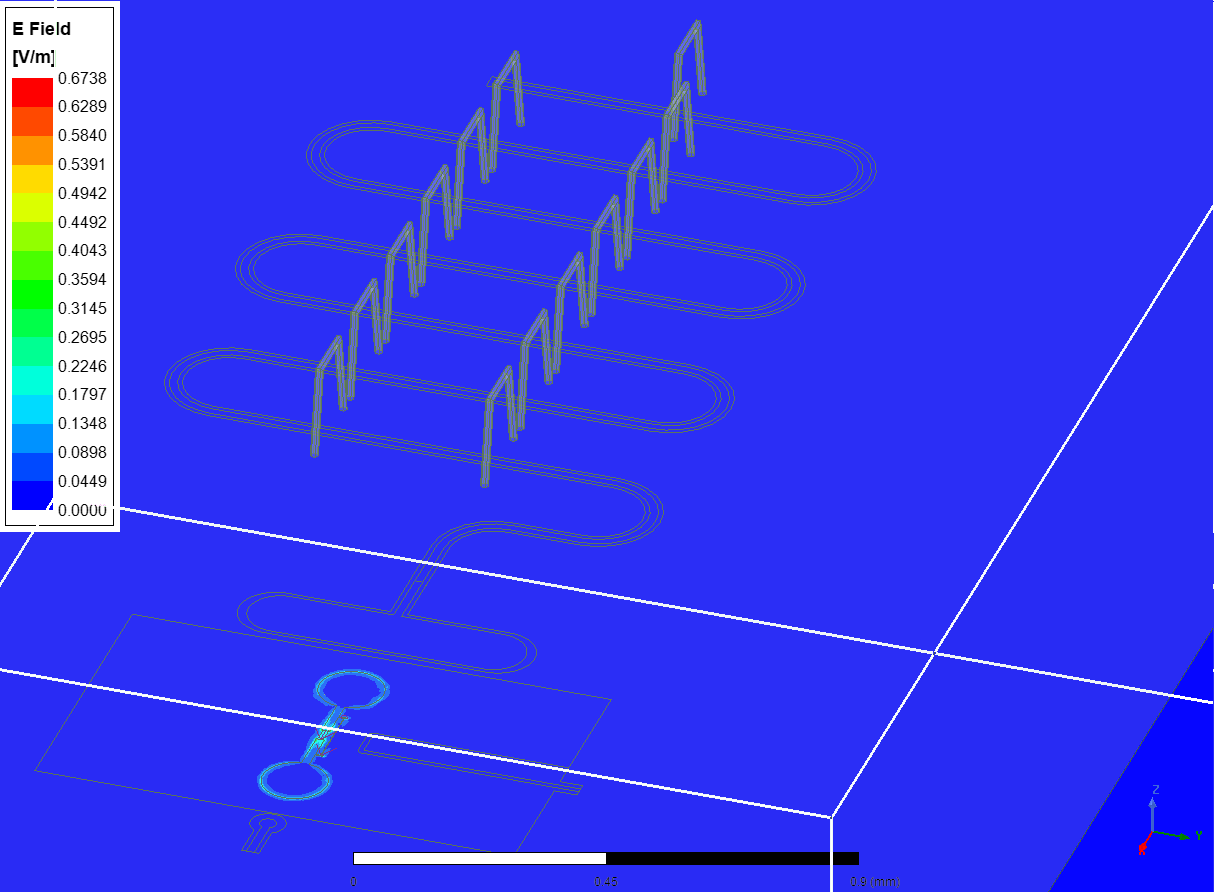

WindowsPath('C:/Users/figenyilmaz/Desktop/qiskit-metal/tutorials_ME/Figen/Fluxonium/GDS-DR/ansys.png')

In [104]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [105]:
hfss.epr_get_frequencies()

Design "Q6_Res6" info:
	# eigenmodes    2
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        6.359071             inf
          1        6.755890             inf

## Extract the GDS file

In [6]:
fluxonium_gds = design.renderers.gds
fluxonium_gds.options

{'short_segments_to_not_fillet': 'True',
 'check_short_segments_by_scaling_fillet': '2.0',
 'gds_unit': 0.001,
 'ground_plane': 'True',
 'negative_mask': {'main': []},
 'fabricate': 'False',
 'corners': 'circular bend',
 'tolerance': '0.00001',
 'precision': '0.000000001',
 'width_LineString': '10um',
 'path_filename': '../resources/Fake_Junctions.GDS',
 'junction_pad_overlap': '5um',
 'max_points': '199',
 'cheese': {'datatype': '100',
  'shape': '0',
  'cheese_0_x': '25um',
  'cheese_0_y': '25um',
  'cheese_1_radius': '100um',
  'view_in_file': {'main': {1: True}},
  'delta_x': '100um',
  'delta_y': '100um',
  'edge_nocheese': '200um'},
 'no_cheese': {'datatype': '99',
  'buffer': '25um',
  'cap_style': '2',
  'join_style': '2',
  'view_in_file': {'main': {1: True}}},
 'bounding_box_scale_x': '1.2',
 'bounding_box_scale_y': '1.2'}

In [7]:
## Check the path and the GDS source file name; they must be the same.
fluxonium_gds.options['path_filename'] = 'FX23_JJ120andArray410_NoMarkers_9by9mm.gds'

In [8]:
fluxonium_gds.options['fabricate'] = True

In [9]:
## you can rename your device
fluxonium_gds.export_to_gds('Six_fluxoniumqubit_design.gds')

03:29PM 06s WARNING [_give_rotation_center_twopads]: In junction table, component=Q1 with name=inductor has width=0.001 smaller than cell dimension=0.017.
03:29PM 06s WARNING [_give_rotation_center_twopads]: In junction table, component=Q6 with name=inductor has width=0.001 smaller than cell dimension=0.017.
03:29PM 06s WARNING [_give_rotation_center_twopads]: In junction table, component=Q2 with name=inductor has width=0.001 smaller than cell dimension=0.017.
03:29PM 06s WARNING [_give_rotation_center_twopads]: In junction table, component=Q5 with name=inductor has width=0.001 smaller than cell dimension=0.017.
03:29PM 06s WARNING [_give_rotation_center_twopads]: In junction table, component=Q3 with name=inductor has width=0.001 smaller than cell dimension=0.017.
03:29PM 06s WARNING [_give_rotation_center_twopads]: In junction table, component=Q4 with name=inductor has width=0.001 smaller than cell dimension=0.017.
03:29PM 06s WARNING [_import_junctions_to_one_cell]: From the "junctio

1

In [107]:
gui.main_window.close()

True